# fit1 

In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

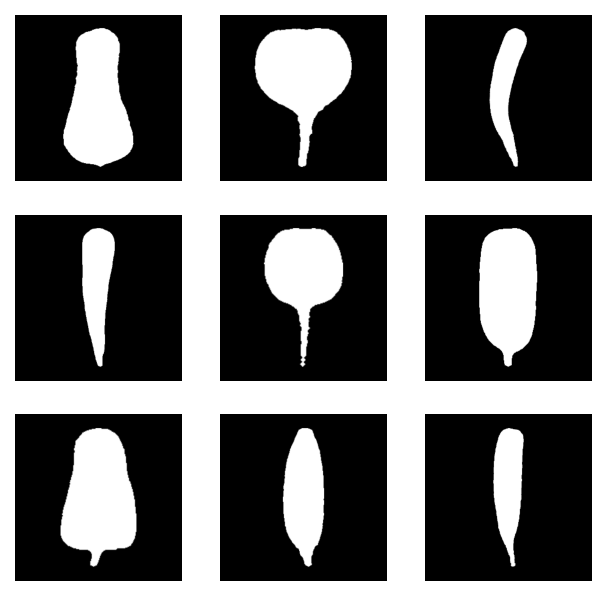

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll,tover=0.1,tunder=-0.1)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting3(func,ts,cont,of_th=1.0):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0],odds0,"span",span)
    return odds # 

# メモ
以下の実験ではオーバフィッティング判定を0.5×平均区間長として実験しているが、停止条件となっている誤り誤差にも比例させるべきなので論文にまとめる際には、0.5 の代わりに、err_th をあてはめて結果を読み替える。

標本点間平均間隔

In [5]:
for imgn in range(9):
    img = imgs[imgn]
    cont = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Nsamples = 65
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    print(imgn,axlength,span)

0 682.1442233324051 10.65850348956883
1 750.6122596263885 11.728316556662321
2 592.5168067216873 9.258075105026364
3 570.2081507444382 8.909502355381846
4 725.0142805576324 11.328348133713007
5 630.4751765727997 9.851174633949995
6 697.1025931835175 10.89222801849246
7 584.0193328857422 9.125302076339722
8 569.7644996643066 8.902570307254791


標本点間の輪郭点列を距離で４等分したときの４分位点3点と標本点2点の計5点の位置ずれの標本偏差を平均区間長で割った値がしきい値（デフォルト０．５）以上であればオーバフィッティングであると判断することにする。

In [5]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=1.0):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    start = time.process_time()
    cps, func,(err,trynum) = bez.fit1T(tpara=[],mode=mode,maxTry=3000,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True,withEC=True)
    etime = time.process_time() - start
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return trynum,etime,err,isOverFitting3(func,bez.ts,conAll,of_th=of_th)

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=1.0):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    start = time.process_time()
    cps, func,(err,trynum) = bez.fit1(tpara=[],maxTry=3000,err_th=err_th,pat=pat,withErr=True,withEC=True)
    etime = time.process_time() - start
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return trynum,etime,err,isOverFitting3(func,bez.ts,conAll,of_th=of_th)

## img0

....................................................................................................
...................
CP 5.0, steps:118, etime: 114.12500 err: 4.9624985230
......................................................
CP 2.0, steps:172, etime: 164.92188 err: 1.9721212075
...........................
..............................E

[] [array([2.39238053, 2.80317983, 2.35396189])]


(0.9946022153842403, array([], dtype=int64))

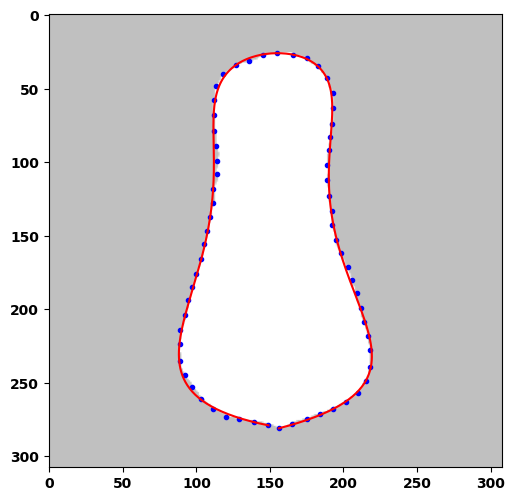

In [9]:
testOF1(imgn=0,N=7,err_th=1)

....................................................................................................
...................
CP 5.0, steps:118, etime: 115.96875 err: 4.9624985230
......................................................
CP 2.0, steps:172, etime: 167.21875 err: 1.9721212075
...........................
..............................
CP 1.0, steps:229, etime: 221.17188 err: 0.9946022154
......................................................................
..............................................................................E

[] [array([1.79170299, 1.94704454])]


(0.6499764370583019, array([], dtype=int64))

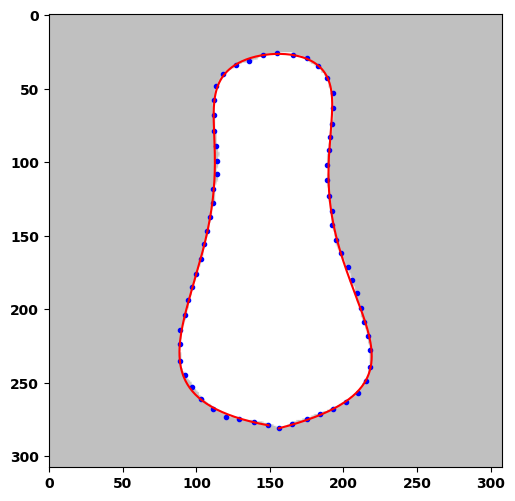

In [10]:
testOF1(imgn=0,N=7,err_th=0.65)

.........................
CP 5.0, steps:24, etime: 38.79688 err: 4.9770368559
..................................................
CP 2.0, steps:74, etime: 107.09375 err: 1.9885296651
.........................
.........................
CP 1.0, steps:124, etime: 175.85938 err: 0.9955750973
.^........................................................................
CP 0.65, steps:198, etime: 277.76562 err: 0.6499424792
.
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1676, 0.5069618319498032, array([], dtype=int64))

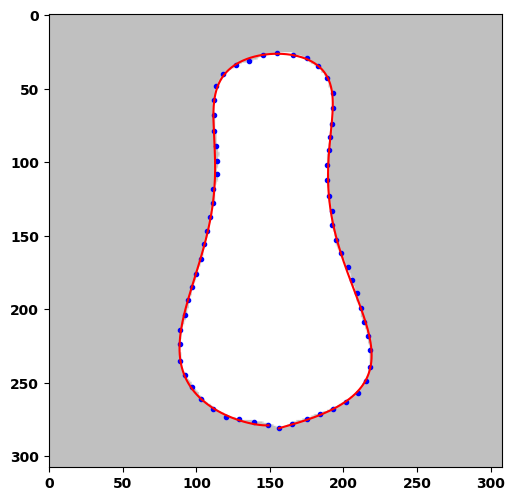

In [29]:
testOF1(imgn=0,N=9,err_th=0.5,of_th=0.5)

.........................
CP 5.0, steps:24, etime: 40.74949 err: 4.9770368565
..................................................
CP 2.0, steps:74, etime: 112.43270 err: 1.9885296647
.........................
.........................
CP 1.0, steps:124, etime: 183.72890 err: 0.9955750969
.^........................................................................
CP 0.65, steps:198, etime: 289.31439 err: 0.6499424791
.
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5069618319386983, array([], dtype=int64))

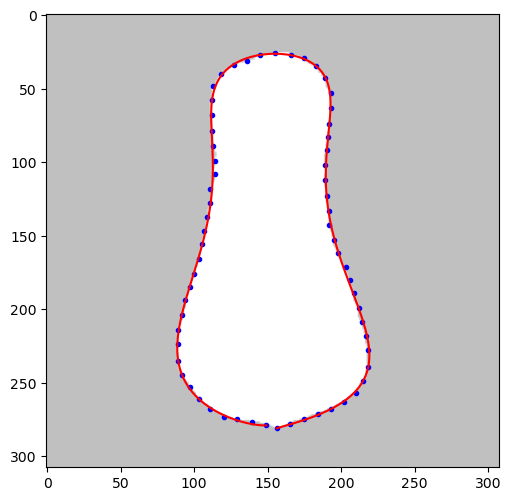

In [25]:
testOF1(imgn=0,N=9,err_th=0.5,of_th=0.5)

.........................
CP 5.0, steps:24, etime: 44.64062 err: 4.9331068032
................................................
CP 2.0, steps:72, etime: 122.73438 err: 1.9897661704
...........................
.................
CP 1.0, steps:116, etime: 193.84375 err: 0.9943301736
...............................^^......................
CP 0.65, steps:171, etime: 282.87500 err: 0.6498658017
............................
...............................^^^^^^^^^^^^^..................................E

[] [array([2.03344446])]


(277, 0.49960220977184067, array([], dtype=int64))

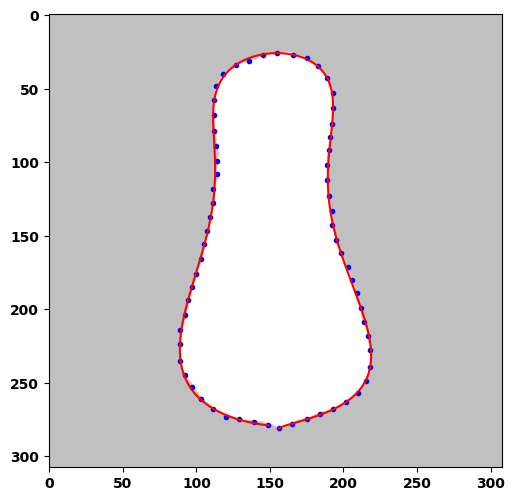

In [28]:
testOF1(imgn=0,N=10,err_th=0.5,of_th=0.5)

## img1

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............^^^^^^^^^^^^.........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................C

[] [array([6.33750449, 5.35442855, 6.52321782, 6.6973075 , 8.05875653,
       5.68101119, 6.91509347])] (array([25, 27, 31, 32, 33, 36, 38], dtype=int64)

(835, 1086.90625, 5.59816684933509, array([], dtype=int64))

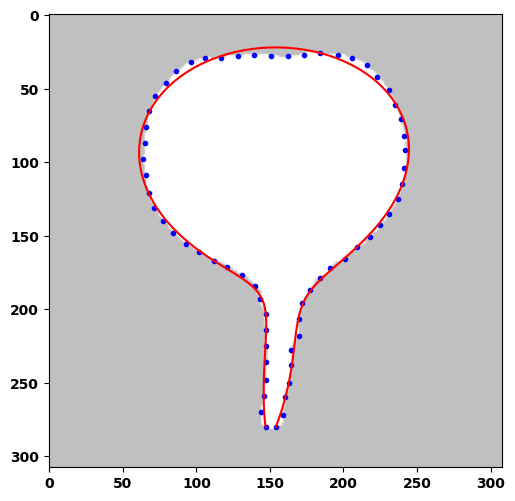

In [23]:
testOF1(imgn=1,N=9,err_th=5,of_th=5)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............^^^^^^^^^^^^.........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................C

[] [array([6.3375045 , 5.35442855, 6.52321782, 6.6973075 , 8.05875653,
       5.68101119, 6.91509347])]


(9, 835, 5.59816684933672, array([], dtype=int64))

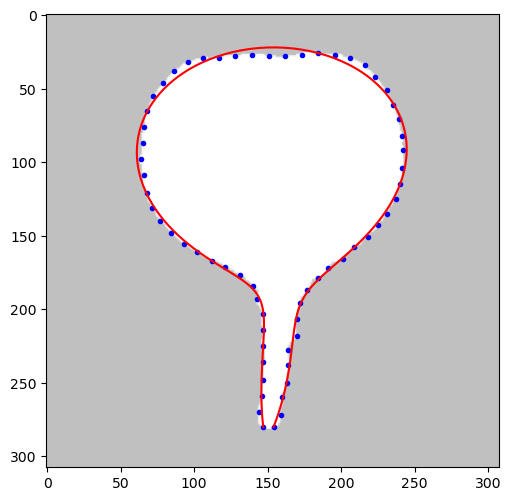

In [49]:
testOF1(imgn=1,N=9,err_th=5,of_th=5)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............^^^^^^^^^^^^.........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................C

[] [array([6.3375045 , 5.35442855, 6.52321782, 6.6973075 , 8.05875653,
       5.68101119, 6.91509347])]


(5.59816684933672, array([], dtype=int64))

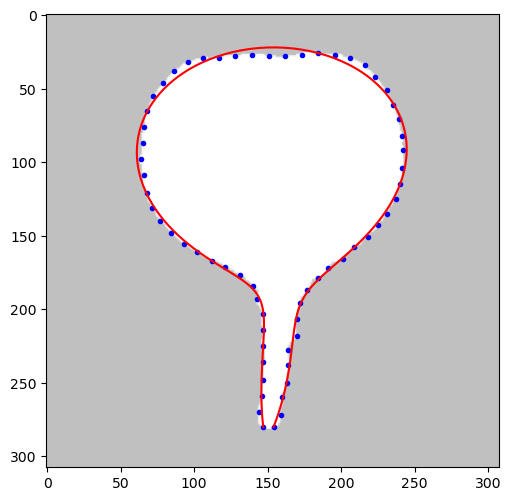

In [47]:
testOF1(imgn=1,N=9,err_th=5,of_th=5)

....
CP 5.0, steps:3, etime: 10.60938 err: 4.7721506974
................................................................................................
...................................................
CP 2.0, steps:150, etime: 237.31250 err: 1.9974661346
.................................................
....................................................................................................
..................................
CP 1.0, steps:333, etime: 521.31250 err: 0.9996290849
..................................................................
.....................................................^^^^^^^^^^^^^^....................^............
............^....^.....^....^....^....^...^...^...
CP 0.65, steps:549, etime: 869.76562 err: 0.6498921715
^...^....^^....^....^....^^...^.....^^....^^...^..
.....^^......^^.....................................................................................
...........................................................................

(3000, 4747.640625, 0.5465604976499749, array([], dtype=int64))

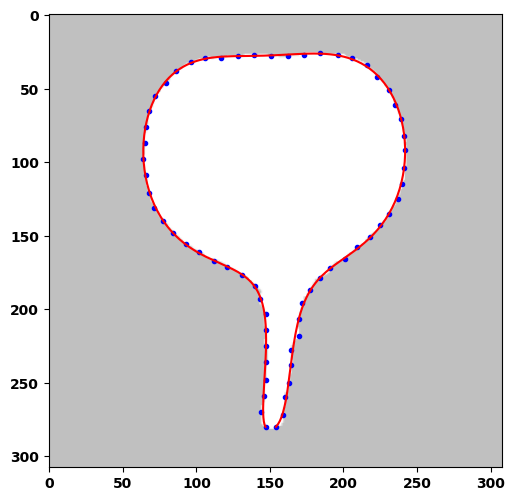

In [20]:
testOF1(imgn=1,N=10,err_th=0.5,of_th=0.5)

....
CP 5.0, steps:3, etime: 10.56250 err: 4.7721506974
................................................................................................
...................................................
CP 2.0, steps:150, etime: 240.09375 err: 1.9974661346
.................................................
....................................................................................................
..................................
CP 1.0, steps:333, etime: 525.62500 err: 0.9996290849
..................................................................
.....................................................^^^^^^^^^^^^^^....................^............
............^....^.....^....^....^....^...^...^...
CP 0.65, steps:549, etime: 869.78125 err: 0.6498921715
^...^....^^....^....^....^^...^.....^^....^^...^..
.....^^......^^.....................................................................................
...........................................................................

(0.5465604976499749, array([], dtype=int64))

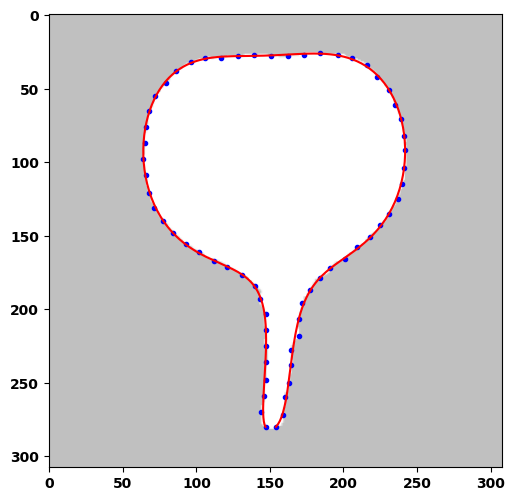

In [16]:
testOF1(imgn=1,N=10,err_th=0.5)

....
CP 5.0, steps:3, etime: 10.60938 err: 4.7721506974
................................................................................................
...................................................
CP 2.0, steps:150, etime: 237.31250 err: 1.9974661346
.................................................
....................................................................................................
..................................
CP 1.0, steps:333, etime: 521.31250 err: 0.9996290849
..................................................................
.....................................................^^^^^^^^^^^^^^....................^............
............^....^.....^....^....^....^...^...^...
CP 0.65, steps:549, etime: 869.76562 err: 0.6498921715
^...^....^^....^....^....^^...^.....^^....^^...^..
.....^^......^^.....................................................................................
...........................................................................

(3000, 4747.640625, 0.5465604976499749, array([], dtype=int64))

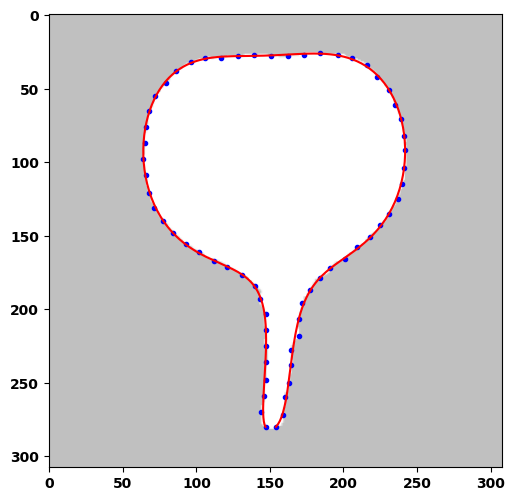

In [20]:
testOF1(imgn=1,N=10,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 7.85595 err: 2.0512472229
.
CP 2.0, steps:1, etime: 10.45537 err: 1.7320663682
.......................................................
CP 1.0, steps:56, etime: 153.21493 err: 0.9964319854
...........................................
....................................................................................................
.................................................E

[] [array([2.29053135, 3.37609007, 3.06819449, 4.59851299])]


(0.6498564130733623, array([], dtype=int64))

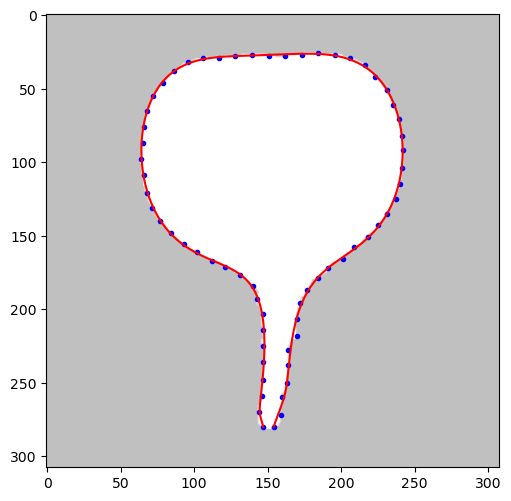

In [28]:
testOF1(imgn=1,N=13,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 7.85331 err: 2.0512472229
.
CP 2.0, steps:1, etime: 10.47394 err: 1.7320663682
.......................................................
CP 1.0, steps:56, etime: 153.18458 err: 0.9964319854
...........................................
....................................................................................................
.................................................
CP 0.65, steps:248, etime: 649.34844 err: 0.6498564131
...................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......^^^...........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^...................

(0.5303816306212628, array([], dtype=int64))

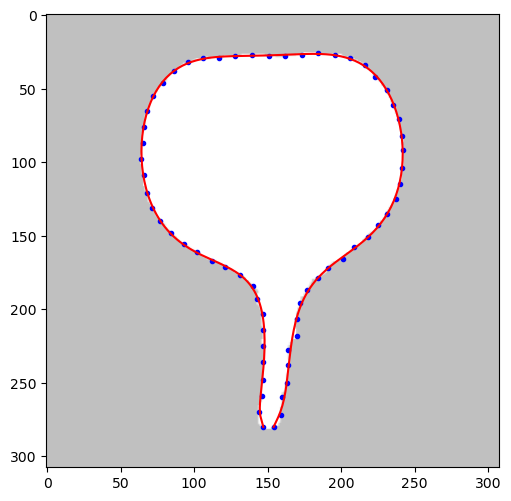

In [29]:
testOF1(imgn=1,N=13,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 7.81250 err: 1.1670198282
.
CP 2.0, steps:1, etime: 10.51562 err: 1.0337059654
.
CP 1.0, steps:2, etime: 13.21875 err: 0.9748332853
...................................................
CP 0.65, steps:53, etime: 148.95312 err: 0.6483256985
..............................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................

(1175, 0.5205767876354217, array([], dtype=int64))

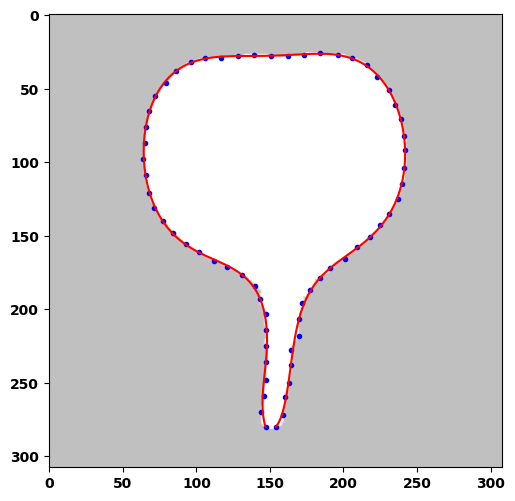

In [31]:
testOF1(imgn=1,N=14,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 8.48032 err: 1.1670198310
.
CP 2.0, steps:1, etime: 11.45092 err: 1.0337059665
.
CP 1.0, steps:2, etime: 14.41414 err: 0.9748332849
...................................................
CP 0.65, steps:53, etime: 164.34791 err: 0.6483256995
..............................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................

(0.5205767875950245, array([], dtype=int64))

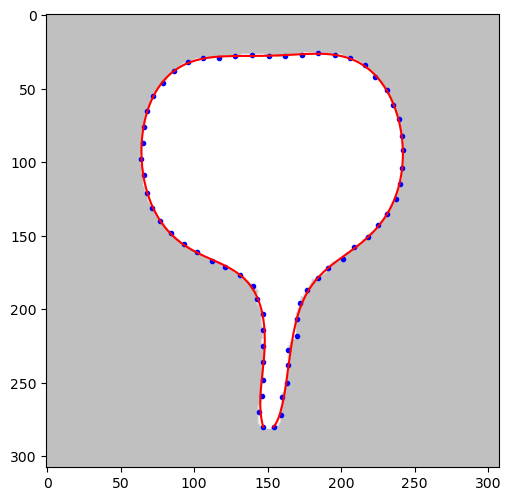

In [26]:
testOF1(imgn=1,N=14,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 8.39062 err: 0.8977657027
.
CP 2.0, steps:1, etime: 11.45312 err: 0.7600065532
.
CP 1.0, steps:2, etime: 14.46875 err: 0.7099507184
.....
CP 0.65, steps:7, etime: 29.57812 err: 0.6494533258
.............................................................................E

[] [array([2.92406225])]


(84, 0.4999768083540902, array([], dtype=int64))

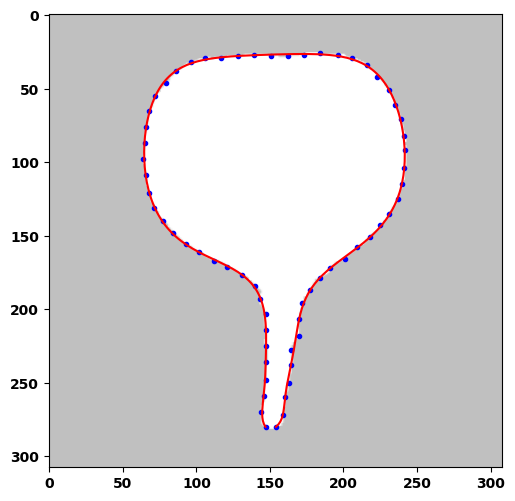

In [30]:
testOF1(imgn=1,N=15,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 9.35454 err: 0.8977657049
.
CP 2.0, steps:1, etime: 12.71925 err: 0.7600065540
.
CP 1.0, steps:2, etime: 16.04540 err: 0.7099507191
.....
CP 0.65, steps:7, etime: 32.82720 err: 0.6494533252
.............................................................................E

[] [array([2.92406225])]


(0.4999768086247996, array([], dtype=int64))

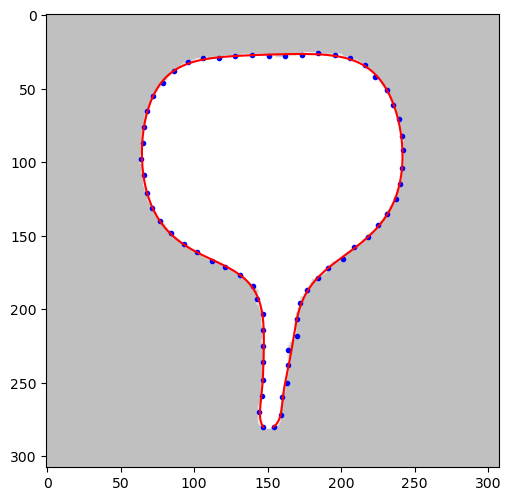

In [24]:
testOF1(imgn=1,N=15,err_th=0.5,of_th=0.5)

## img2

..............
CP 5.0, steps:13, etime: 12.71875 err: 4.9715770942
......................................................................................
....................
CP 2.0, steps:119, etime: 105.03125 err: 1.9992877280
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

(1.1102271933873824, array([], dtype=int64))

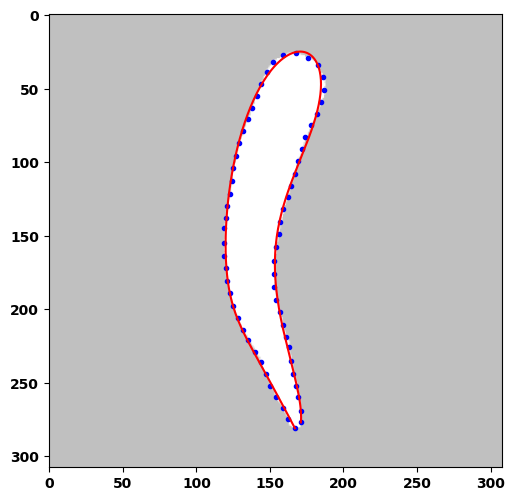

In [14]:
testOF1(imgn=2,N=7,err_th=0.5)

..
CP 5.0, steps:1, etime: 6.93750 err: 4.0838808544
......
CP 2.0, steps:7, etime: 15.39062 err: 1.9852799902
..............................................^.............................................
...........................
CP 1.0, steps:126, etime: 177.15625 err: 0.9998624286
.........................................................................
....................................................................................................
............................................................................................^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........
....................................................................................................
....................................................................................................
.................................................^^.^^.^.^.^..^^....^...............................
..................................

(0.8205453057721351, array([], dtype=int64))

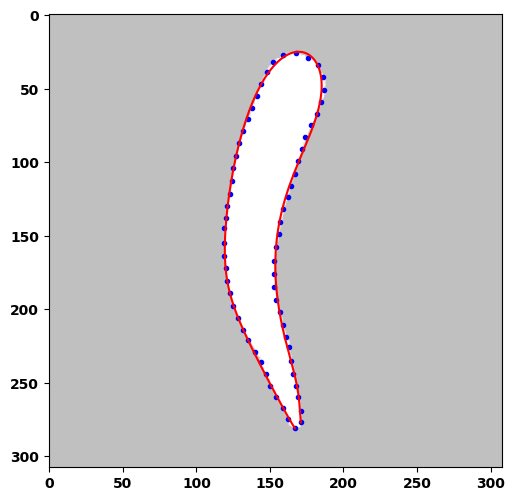

In [71]:
testOF1(imgn=2,N=9,err_th=0.65,of_th=0.65)

..
CP 5.0, steps:1, etime: 8.53125 err: 3.9370709604
..........
CP 2.0, steps:11, etime: 24.25000 err: 1.9932298423
......................................................................
CP 1.0, steps:81, etime: 133.62500 err: 0.9980659371
..................
....................................................................................................
..............................^.........^^........^^........^^.......^^........^^.......^^.......^^.
.......^^........^^........^^........^^........^^.........^^.........^^.......^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^...............................................................^^..........................
...............................................^.................^.........^........^.........^.....
...^........^.........^........^.......^^^^^.^.^.^.^.^.^.^^^^^^^^^^^^^^^^^..........................
.................................................................
CP 0.65, steps:764, etime: 1190.93750 err: 0.6499025881
.............

(0.5282119207476988, array([], dtype=int64))

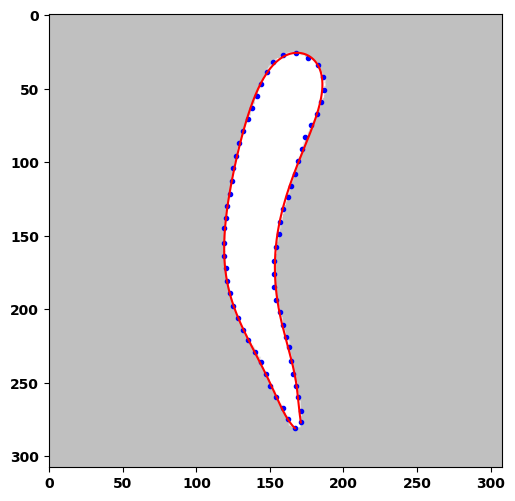

In [14]:
testOF1(imgn=2,N=10,err_th=0.5)

..
CP 5.0, steps:1, etime: 7.31250 err: 3.9370709604
..........
CP 2.0, steps:11, etime: 22.79688 err: 1.9932298423
......................................................................
CP 1.0, steps:81, etime: 131.73438 err: 0.9980659371
..................
....................................................................................................
..............................^.........^^........^^........^^.......^^........^^.......^^.......^^.
.......^^........^^........^^........^^........^^.........^^.........^^.......^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^...............................................................^^..........................
...............................................^.................^.........^........^.........^.....
...^........^.........^........^.......^^^^^.^.^.^.^.^.^.^^^^^^^^^^^^^^^^^..........................
.................................................................E



(0.6499025881326048, array([], dtype=int64))

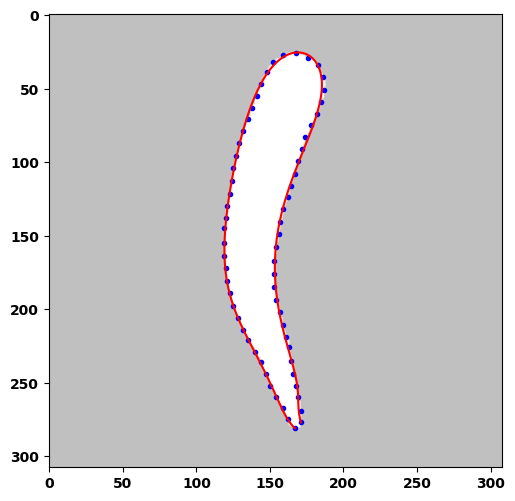

In [70]:
testOF1(imgn=2,N=10,err_th=0.65,of_th=0.65)

..
CP 5.0, steps:1, etime: 7.88700 err: 3.9370709631
..........
CP 2.0, steps:11, etime: 24.83507 err: 1.9932298424
......................................................................E

[] [array([1.99667182, 2.01118476, 2.49737476])]


(0.9980659369222259, array([], dtype=int64))

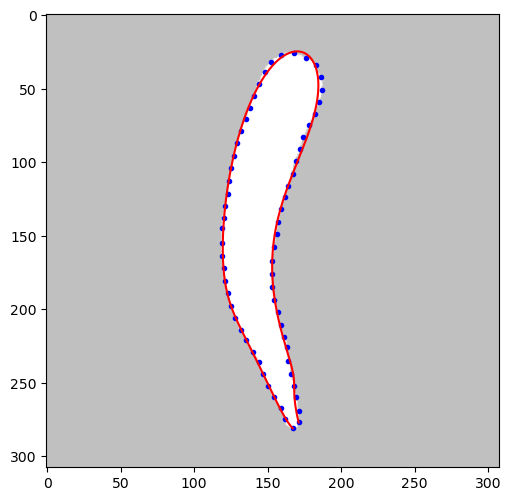

In [30]:
testOF1(imgn=2,N=10,err_th=1.0,of_th=1.0)

..
CP 5.0, steps:1, etime: 7.29688 err: 3.9370709604
..........
CP 2.0, steps:11, etime: 22.78125 err: 1.9932298423
......................................................................
CP 1.0, steps:81, etime: 129.90625 err: 0.9980659371
..................
....................................................................................................
..............................^.........^^........^^........^^.......^^........^^.......^^.......^^.
.......^^........^^........^^........^^........^^.........^^.........^^.......^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^...............................................................^^..........................
...............................................^.................^.........^........^.........^.....
...^........^.........^........^.......^^^^^.^.^.^.^.^.^.^^^^^^^^^^^^^^^^^..........................
.................................................................
CP 0.65, steps:764, etime: 1197.89062 err: 0.6499025881
.............

(5268, 0.5282119207476988, array([], dtype=int64))

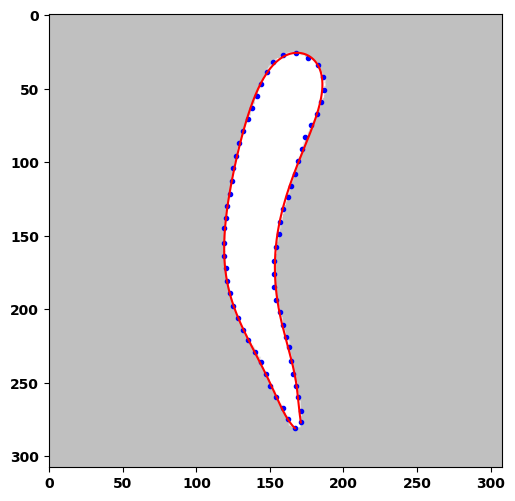

In [32]:
testOF1(imgn=2,N=10,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.43750 err: 3.1895783749
..
CP 2.0, steps:2, etime: 10.21875 err: 1.8680617052
...........................
CP 1.0, steps:29, etime: 61.28125 err: 0.9946766919
......................................................................
....................................................................................................
.....................................................
CP 0.65, steps:252, etime: 472.42188 err: 0.6498434784
...............................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................^...................
.................................................................................

(871, 0.4999811852523609, array([], dtype=int64))

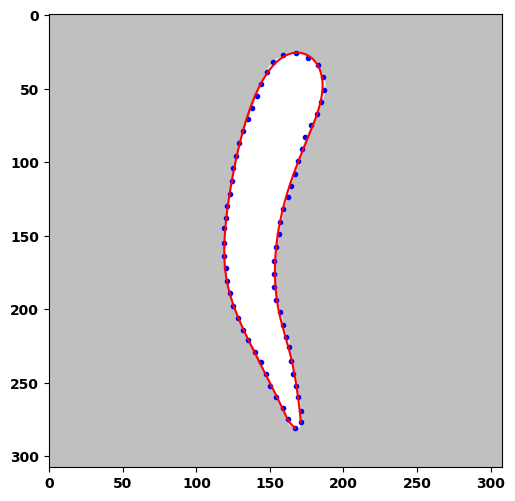

In [34]:
testOF1(imgn=2,N=11,err_th=0.5,of_th=0.5)

.......
CP 5.0, steps:6, etime: 8.23438 err: 4.6434441746
.........................
CP 2.0, steps:31, etime: 34.75000 err: 1.9916567540
..................................................^^^^^^^^^^...^....
.......^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^..........................
.................................................^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^^.^.^.^^.^.^..^.^.^..^.^.^..^...^^.^.^.^.^.^.^.^.^.^.^
.^.^..^....^....^....^.^^....^.^^....^.^^..^.^^..^.^^..^.....^^..^...^...^...^...^...^...^...^...^..
.^...^...^^^..^^...^^...^^....^^....^^......^^......^^......^^.......^^........^^.........^.........
.^......................................................................................

(0.9158429469224321, array([], dtype=int64))

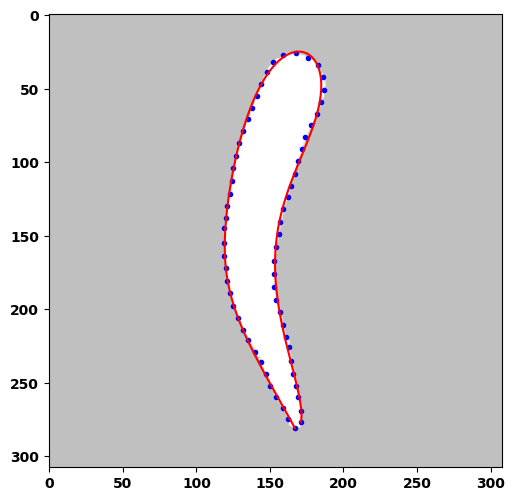

In [15]:
testOF1(imgn=2,N=11,err_th=0.5,of_th=0.5)

## img3

....................
CP 5.0, steps:19, etime: 22.01562 err: 4.9937404532
................................................................................
....................................................................................................
.................
CP 2.0, steps:216, etime: 205.26562 err: 1.9994713665
...................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1.11346725427879, array([], dtype=int64))

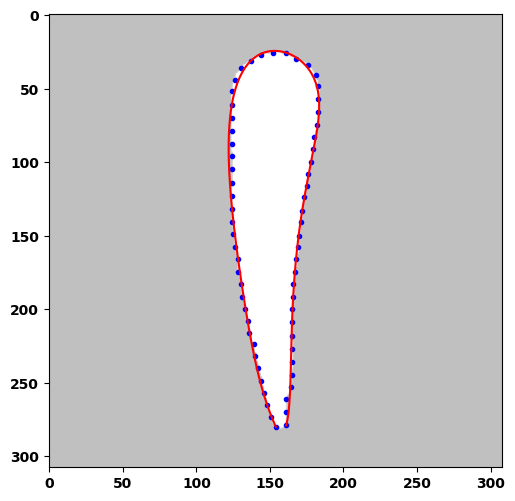

In [85]:
testOF1(imgn=3,N=7,err_th=1,of_th=1)

.......................
CP 5.0, steps:22, etime: 28.42188 err: 4.9235190622
..........................................
CP 2.0, steps:64, etime: 74.59375 err: 1.9781023902
.............................^.^.^.
^.^.^.^.^.^.^.^....................................^^...^^.^^^..^^^.^^^.^^^...^^^^..........^^^^^...
....^^^^^^..................................................................................^^^^^^^^
^^^^^^^.^^^^^^^^^^^^^^^^..E

span 8.909502355381846
[] [array([2.25947969, 2.67011327, 2.01865667])]


(0.9991819019000201, array([], dtype=int64))

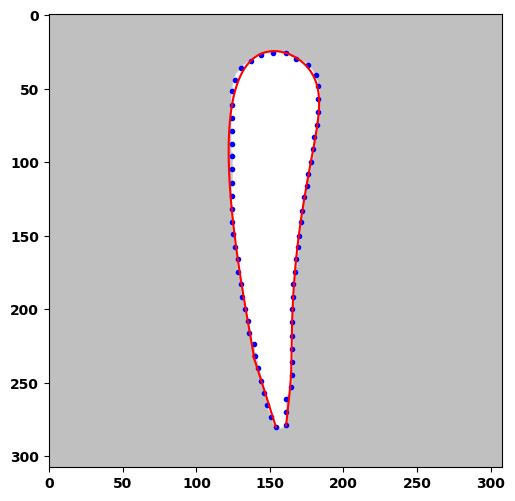

In [84]:
testOF1(imgn=3,N=8,err_th=1,of_th=1)

.......................
CP 5.0, steps:22, etime: 30.84012 err: 4.9235190622
..........................................
CP 2.0, steps:64, etime: 80.36755 err: 1.9781023902
.............................^.^.^.
^.^.^.^.^.^.^.^....................................^^...^^.^^^..^^^.^^^.^^^...^^^^..........^^^^^...
....^^^^^^..................................................................................^^^^^^^^
^^^^^^^.^^^^^^^^^^^^^^^^..
CP 1.0, steps:325, etime: 387.71067 err: 0.9991819019
^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^...................................................................................
...............................

(0.8125100299548395, array([], dtype=int64))

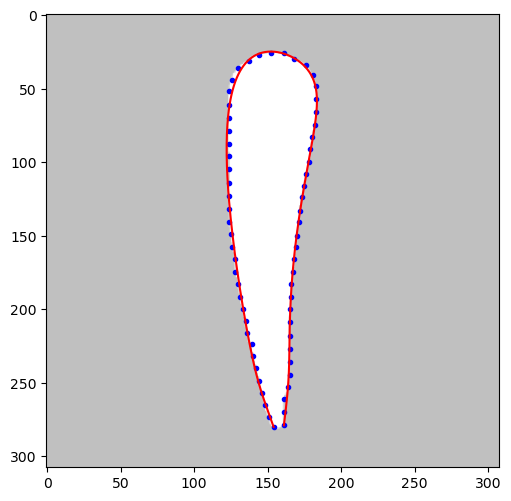

In [35]:
testOF1(imgn=3,N=8,err_th=0.65,of_th=0.65)

..
CP 5.0, steps:1, etime: 7.26369 err: 4.3713719404
............................................................
CP 2.0, steps:61, etime: 93.94586 err: 1.9951129682
......................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................
CP 1.0, steps:579, etime: 836.07290 err: 0.9999075137
....................
....................................................................................................
....................................................................................................
.................................

(0.6499819693373214, array([], dtype=int64))

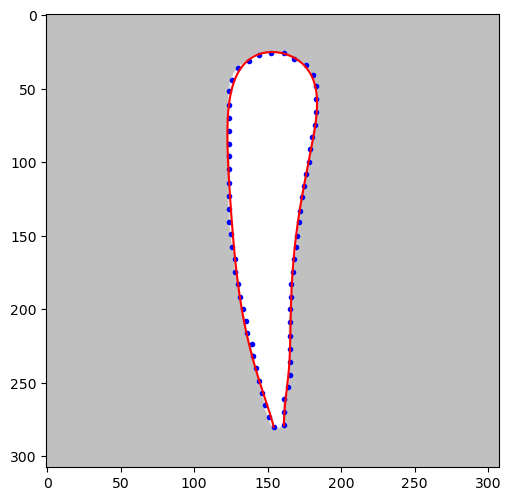

In [34]:
testOF1(imgn=3,N=9,err_th=0.65,of_th=0.65)

..
CP 5.0, steps:1, etime: 7.04688 err: 4.3713719388
............................................................
CP 2.0, steps:61, etime: 89.95312 err: 1.9951129681
......................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................
CP 1.0, steps:579, etime: 799.09375 err: 0.9999075136
....................
....................................................................................................
....................................................................................................
.................................

(2288, 0.7732162001432493, array([], dtype=int64))

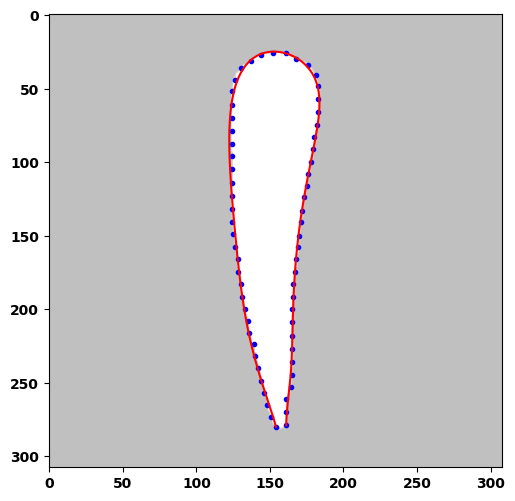

In [36]:
testOF1(imgn=3,N=9,err_th=0.5,of_th=0.5)

...
CP 5.0, steps:2, etime: 9.26562 err: 4.7062308926
...............................
CP 2.0, steps:33, etime: 59.35938 err: 1.9749866377
......................................................
CP 1.0, steps:87, etime: 146.60938 err: 0.9927614503
............
............................................................................
CP 0.65, steps:175, etime: 286.34375 err: 0.6482500775
........................
....................................................................................................
....................................................E

[] [array([1.6849565])]


(351, 0.49974277200447914, array([], dtype=int64))

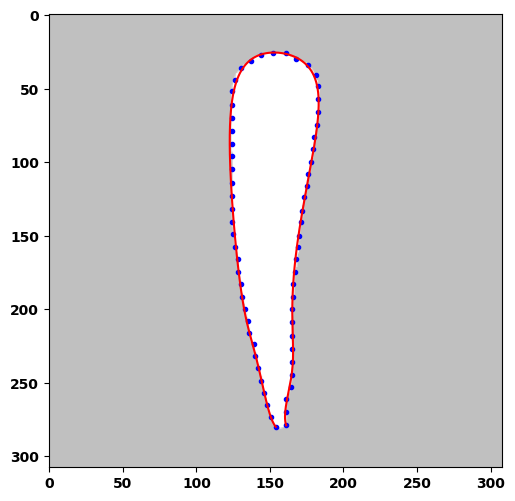

In [35]:
testOF1(imgn=3,N=10,err_th=0.5,of_th=0.5)

...
CP 5.0, steps:2, etime: 9.73983 err: 4.7062308930
...............................
CP 2.0, steps:33, etime: 62.18438 err: 1.9749866379
......................................................
CP 1.0, steps:87, etime: 153.74853 err: 0.9927614503
............
............................................................................E

[] [array([1.70866076, 1.41966642])]


(0.6482500775374226, array([], dtype=int64))

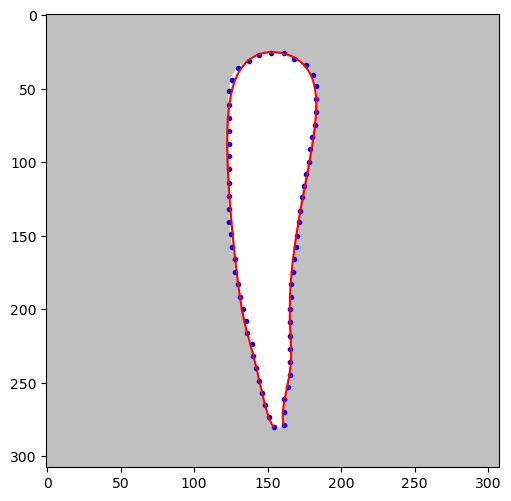

In [33]:
testOF1(imgn=3,N=10,err_th=0.65,of_th=0.65)

## img4

............
CP 5.0, steps:11, etime: 20.57812 err: 4.8711526038
..........................................................................^^............
....^^^.............................................................................................
...............................................................................C

span 11.328348133713007
[] [array([4.45239539, 3.77771528, 4.91025714, 6.59536755, 4.5149938 ,
       3.52553285, 3.23043144])]


(2.5750985890911076, array([], dtype=int64))

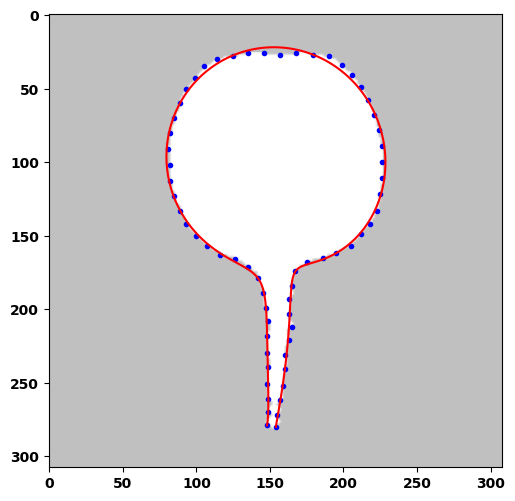

In [87]:
testOF1(imgn=4,N=9,err_th=1,of_th=1)

............
CP 5.0, steps:11, etime: 21.49802 err: 4.8711526086
..........................................................................^^............
....^^^.............................................................................................
...............................................................................C

[] [array([4.45239539, 3.77771528, 4.91025714, 6.59536755, 4.51499381,
       3.52553285, 3.23043144])]


(2.5750985893140954, array([], dtype=int64))

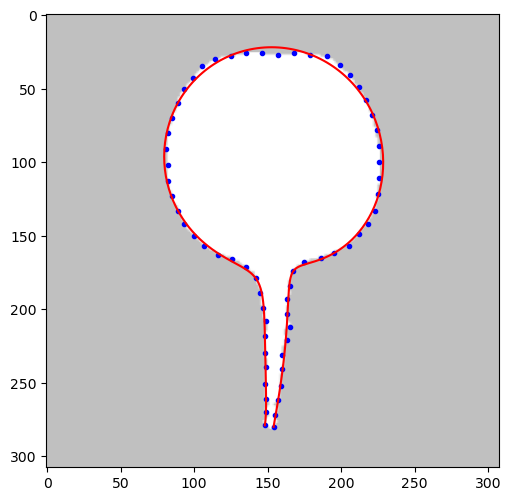

In [32]:
testOF1(imgn=4,N=9,err_th=1.0,of_th=1.0)

...........
CP 5.0, steps:10, etime: 22.21875 err: 4.8920677147
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................^.............................................
....................................................................................................
............................................................................
CP 2.0, steps:675, etime: 1100.73438 err: 1.9998927883
........................
.....................................................^^^....^^^^....^^^^^.......^...................
...................................................................................

(0.9998822812331942, array([], dtype=int64))

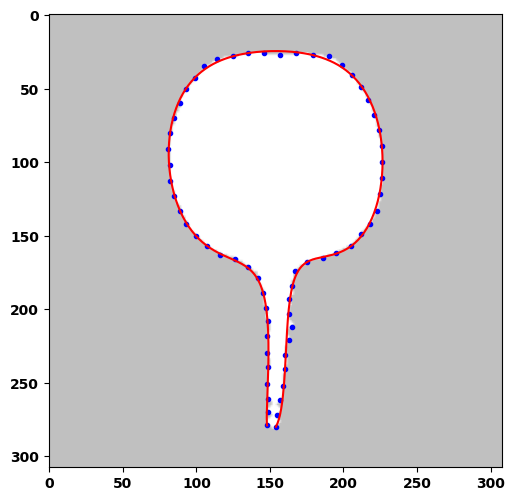

In [88]:
testOF1(imgn=4,N=10,err_th=1,of_th=1)

...........
CP 5.0, steps:10, etime: 23.48325 err: 4.8920677209
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................^.............................................
....................................................................................................
............................................................................
CP 2.0, steps:675, etime: 1155.35192 err: 1.9998927911
........................
.....................................................^^^....^^^^....^^^^^.......^...................
...................................................................................

(0.9998822823018721, array([], dtype=int64))

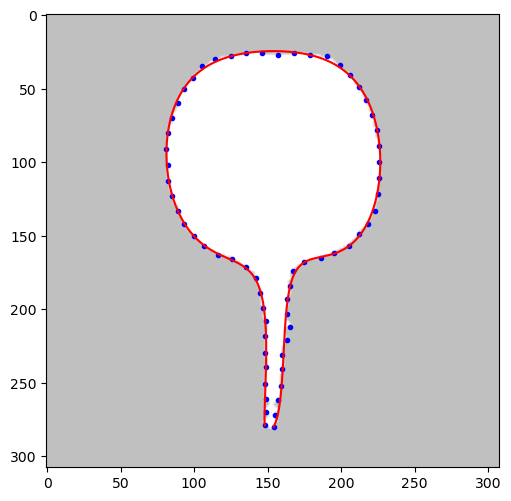

In [40]:
testOF1(imgn=4,N=10,err_th=1,of_th=1)

...........
CP 5.0, steps:10, etime: 21.46875 err: 4.8920677147
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................^.............................................
....................................................................................................
............................................................................
CP 2.0, steps:675, etime: 1072.65625 err: 1.9998927883
........................
.....................................................^^^....^^^^....^^^^^.......^...................
...................................................................................

(3000, 4707.03125, 0.8722336503536425, array([], dtype=int64))

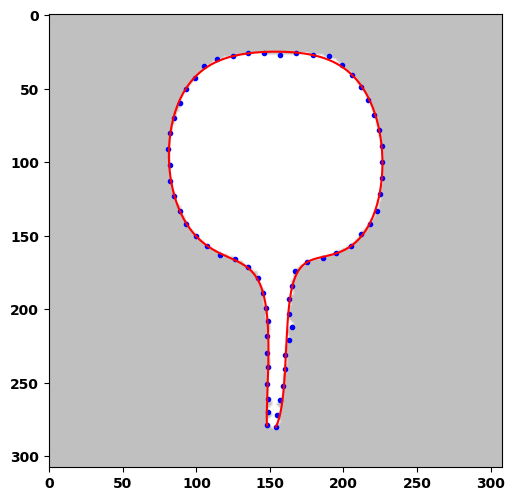

In [30]:
testOF1(imgn=4,N=10,err_th=0.87,of_th=0.87)

...........
CP 5.0, steps:10, etime: 23.51645 err: 4.8920677209
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................^.............................................
....................................................................................................
............................................................................
CP 2.0, steps:675, etime: 1156.66226 err: 1.9998927911
........................
.....................................................^^^....^^^^....^^^^^.......^...................
...................................................................................

(0.9998822823018721, array([], dtype=int64))

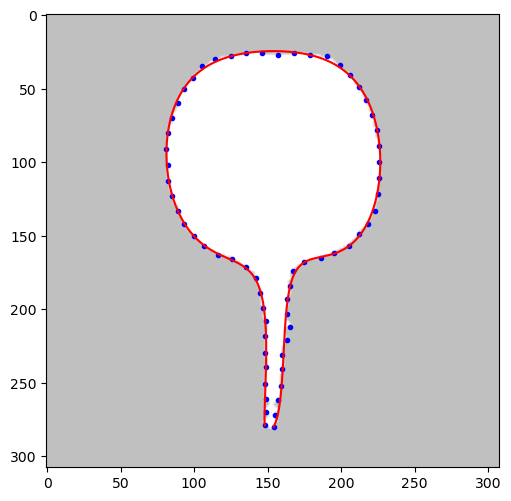

In [36]:
testOF1(imgn=4,N=10,err_th=1,of_th=1)

...........
CP 5.0, steps:10, etime: 23.59602 err: 4.8920677209
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................^.............................................
....................................................................................................
............................................................................
CP 2.0, steps:675, etime: 1145.42343 err: 1.9998927911
........................
.....................................................^^^....^^^^....^^^^^.......^...................
...................................................................................

(0.9998822823018721, array([], dtype=int64))

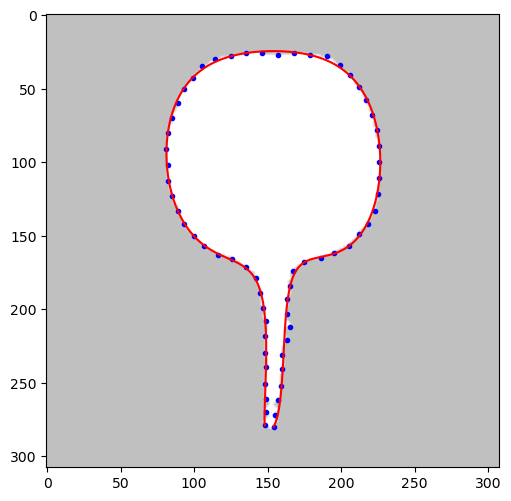

In [31]:
testOF1(imgn=4,N=10,err_th=1.0,of_th=1.0)

.........
CP 5.0, steps:8, etime: 21.62500 err: 4.9612035157
...........................................................................................
...........................^^^^^^^^^................................................................
...........
CP 2.0, steps:210, etime: 404.17188 err: 1.9994923920
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................E

span 11.328348133713007
[] [array([2.31

(0.9988876306897861, array([], dtype=int64))

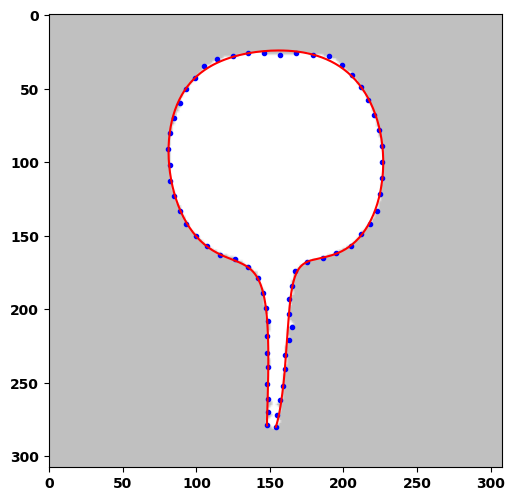

In [86]:
testOF1(imgn=4,N=11,err_th=1,of_th=1)

.........
CP 5.0, steps:8, etime: 22.36433 err: 4.9612035174
...........................................................................................
...........................^^^^^^^^^................................................................
...........
CP 2.0, steps:210, etime: 416.76985 err: 1.9994923892
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................
CP 1.0, steps:842, etime: 1653.37677 err:

(0.6498108130984096, array([], dtype=int64))

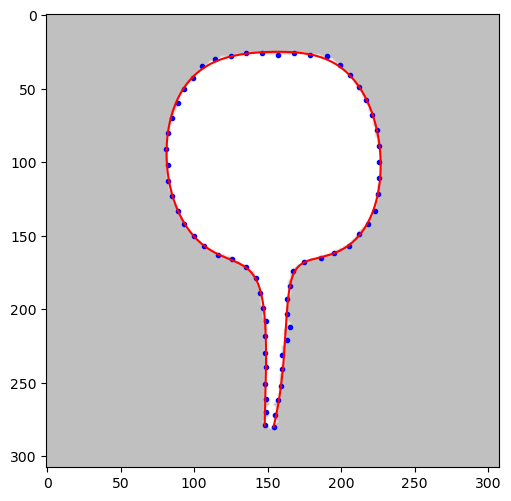

In [41]:
testOF1(imgn=4,N=11,err_th=0.65,of_th=0.65)

.........
CP 5.0, steps:8, etime: 20.64062 err: 4.9612035157
...........................................................................................
...........................^^^^^^^^^................................................................
...........
CP 2.0, steps:210, etime: 379.82812 err: 1.9994923920
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................
CP 1.0, steps:842, etime: 1504.39062 err:

(2997, 5405.890625, 0.5163139716318266, array([], dtype=int64))

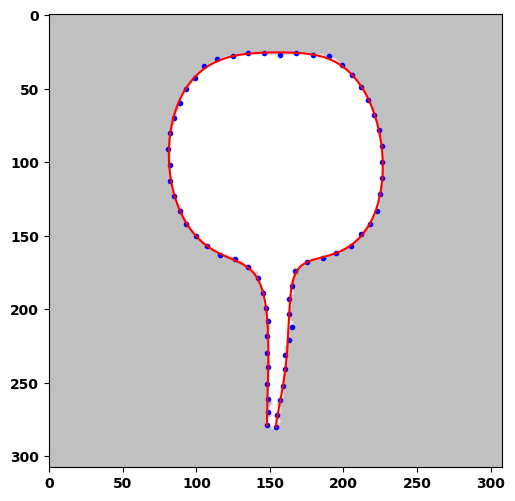

In [6]:
testOF1(imgn=4,N=11,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.87500 err: 4.1975619296
......
CP 2.0, steps:6, etime: 19.65625 err: 1.8522259930
..................................................
CP 1.0, steps:56, etime: 126.25000 err: 0.9994330342
...........................................
...^................................................................................................
....................................................................................................
....................................................................................................
....................^^..............................................................................
..^......^^^.....^^^^....^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^...^^^^^^^^^..^^^^^^^
^.^^^^.^^^^.^^^^^.^^^^^^^^^^..^^^^^^^^^.^^^^^.^^^^^.^^^^^^.^^^^^^.^^^^^^.^^^^^^^^^^^^^.^^^^^^^.^^^^^
^^.^^^^^^^.^^^^^^^^.^^^^^^^^^^^^^^^^..^^^^^^^^^.^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^....^^^^^^^
^^^^^.^^^^^^^^^^^^^.^^^^^^^^^^^^^.^

(2790, 5837.59375, 0.6843336195663922, array([62], dtype=int64))

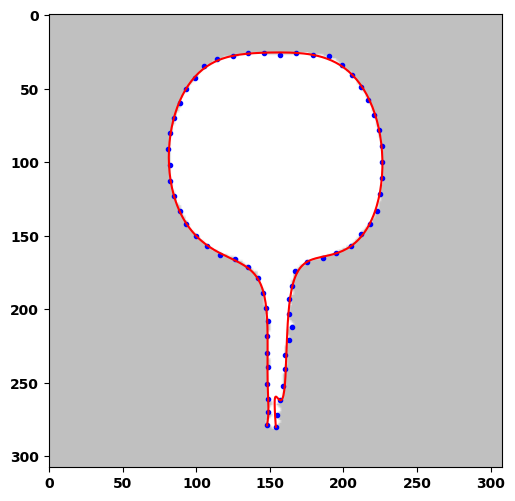

In [7]:
testOF1(imgn=4,N=12,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 7.42188 err: 4.0760508632
.....
CP 2.0, steps:5, etime: 19.87500 err: 1.9866913722
............................
CP 1.0, steps:33, etime: 89.37500 err: 0.9997087408
..................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^......................................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........
CP 0.65, steps:745, etime: 1845.87500 err: 0.6498956776
..................................

(0.49997384297049013, array([], dtype=int64))

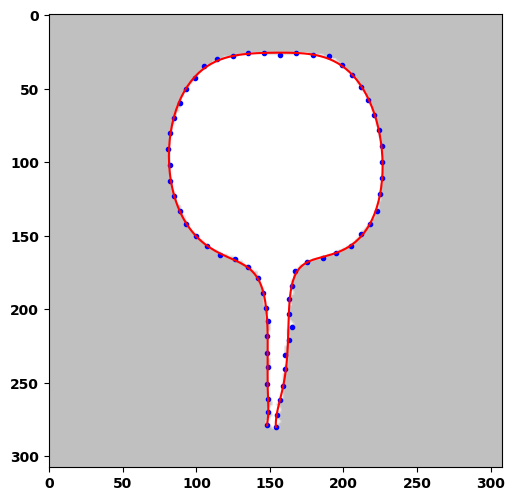

In [93]:
testOF1(imgn=4,N=13,err_th=0.5,of_th=0.5)

## img 5

....................................................................................................
....................................................................................................
....................................................................................................
.........................................................................................^...^...^..
.^...^...^...^.^.....^.....^.....^.....^.....^......................................................
....................................................................................................
....................................................................................................
...........................................................................................^^^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^...^.^.^.^...^
.^.^...^.^...^.^...^..C

[60 62] [array([ 6.4174416 ,  8.30774396, 18.84350046,  8.42148722

(921, 6.8578238217774175, array([60, 62], dtype=int64))

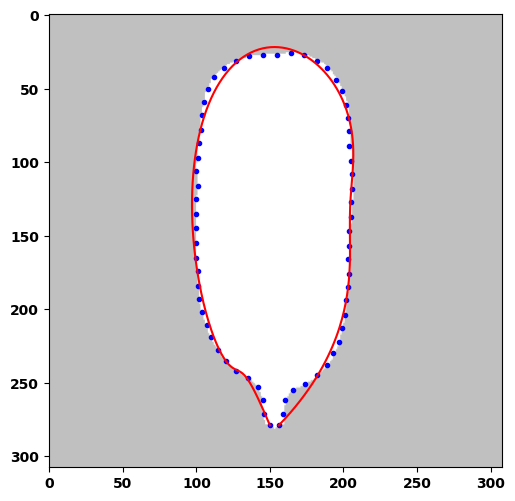

In [47]:
testOF1(imgn=5,N=7,err_th=1,of_th=1)

...........
CP 5.0, steps:10, etime: 15.81250 err: 4.8771531805
.........................................................................................
..............................................
CP 2.0, steps:145, etime: 167.71875 err: 1.9954261278
......................................................
.......^.......................^.......^......^......^.......^......^......^.......^......^......^..
.....^......^^.....^^^^....^^.....^^.....^^.....^^......^^......^^......^^......^^^.....^^^.....^^^.
....^^^.....^^^.....^^^.....^^^....^^^....^^^....^^^....^^^....^^^...^^^^^..........................
.............................................................................................^^.....
.....E

[] [array([2.18201676, 2.21288115, 2.33881248, 2.33519799, 2.6710746 ,
       2.67303251])]


(604, 0.9999983800829922, array([], dtype=int64))

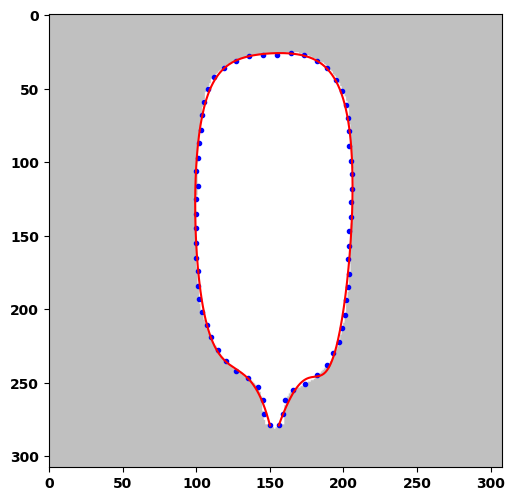

In [46]:
testOF1(imgn=5,N=8,err_th=1,of_th=1)

...........
CP 5.0, steps:10, etime: 15.81250 err: 4.8771531805
.........................................................................................
..............................................
CP 2.0, steps:145, etime: 168.12500 err: 1.9954261278
......................................................
.......^.......................^.......^......^......^.......^......^......^.......^......^......^..
.....^......^^.....^^^^....^^.....^^.....^^.....^^......^^......^^......^^......^^^.....^^^.....^^^.
....^^^.....^^^.....^^^.....^^^....^^^....^^^....^^^....^^^....^^^...^^^^^..........................
.............................................................................................^^.....
.....E

[] [array([2.18201676, 2.21288115, 2.33881248, 2.33519799, 2.6710746 ,
       2.67303251])]


(604, 0.9999983800829922, array([], dtype=int64))

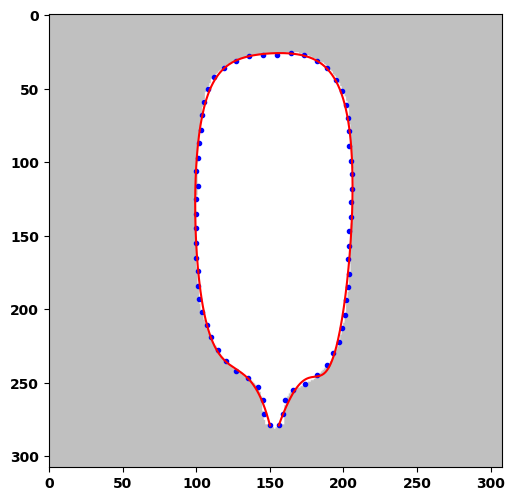

In [37]:
testOF1(imgn=5,N=8,err_th=1,of_th=1)

## img 6

.......................
CP 5.0, steps:22, etime: 41.84375 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 411.28125 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(11817, 0.9654089548899831, array([63], dtype=int64))

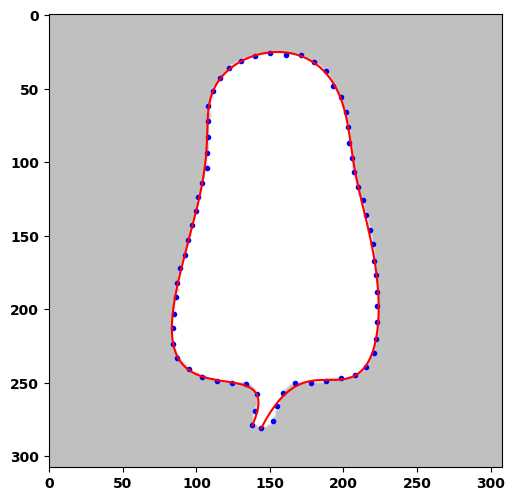

In [48]:
testOF1(imgn=6,N=10,err_th=0.65,of_th=0.65)

.......................
CP 5.0, steps:22, etime: 40.60938 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 400.64062 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(0.9654089548899831, array([62, 63], dtype=int64))

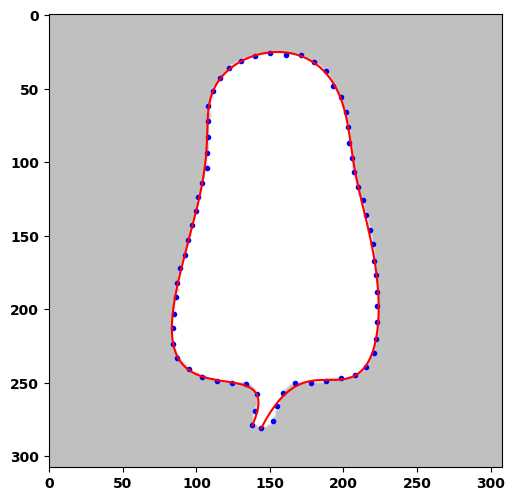

In [9]:
testOF1(imgn=6,N=10,err_th=0.5,of_th=0.5)

.......................
CP 5.0, steps:22, etime: 40.60938 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 400.64062 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(0.9654089548899831, array([62, 63], dtype=int64))

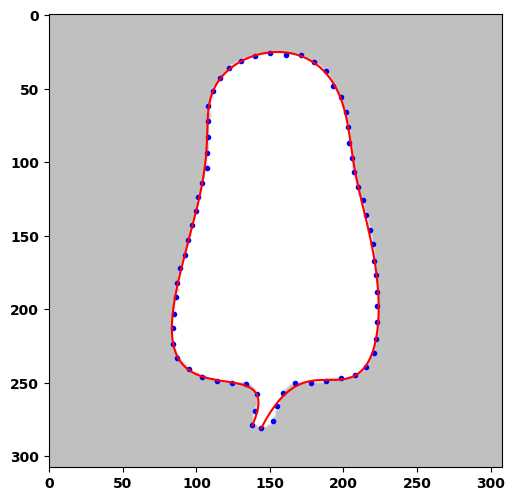

In [9]:
testOF1(imgn=6,N=10,err_th=0.5,of_th=0.5)

.......................
CP 5.0, steps:22, etime: 40.75000 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 407.84375 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(2079, 0.9999777335620085, array([], dtype=int64))

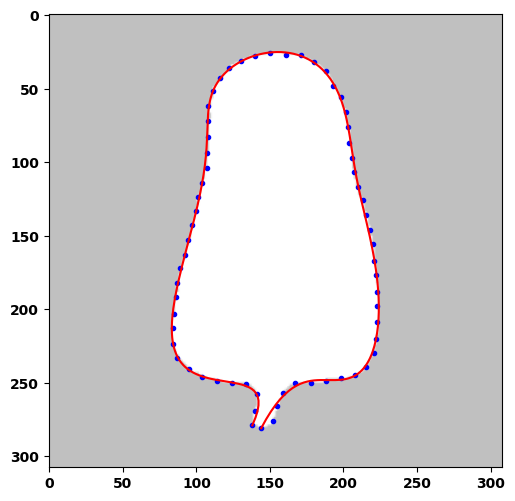

In [20]:
testOF1(imgn=6,N=10,err_th=1,of_th=1.0)

................
CP 5.0, steps:15, etime: 22.01582 err: 4.8939344728
....................................................................................
..............
CP 2.0, steps:113, etime: 130.72637 err: 1.9902440306
......................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................................^^............................
............................................^^^^^^^^...^^^.............^.^.^........................
....^.......^.^...^.^..........^..^..^..^..^..^.^^^^^^^^^^^^..........^..^..^..^..^..^..^.^^...^..^.
^.......^..^..^..^^^.....^..^..^...^.^^...^..^...^...^^^^..^^^^^^..............^^.^^

(1.0183190835230993, array([63]))

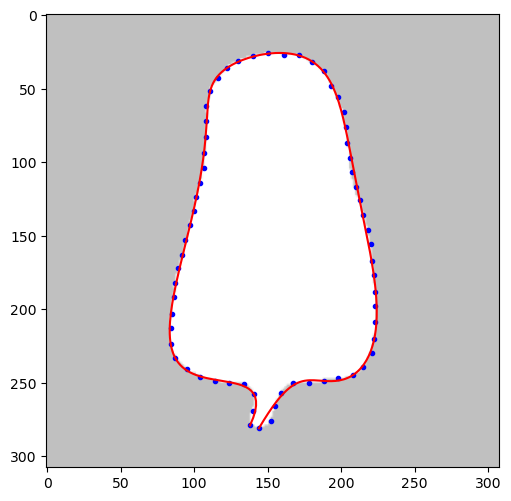

In [46]:
testOF(imgn=6,N=10,mode=1,err_th=0.5,of_th=0.5)

.......................
CP 5.0, steps:22, etime: 39.89062 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 401.07812 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(11817, 0.9654089548899831, array([63], dtype=int64))

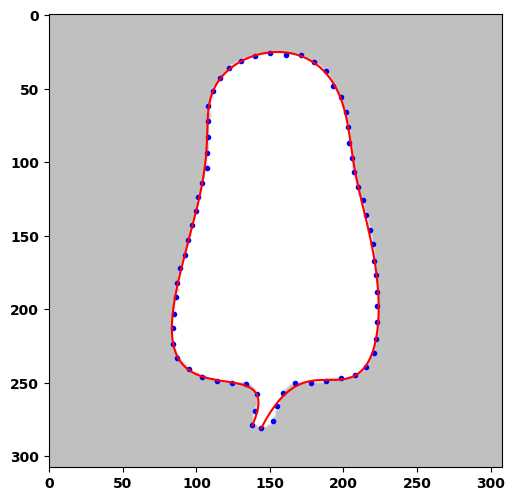

In [22]:
testOF1(imgn=6,N=10,err_th=0.65,of_th=0.65)

..
CP 5.0, steps:1, etime: 8.26562 err: 4.0651379678
.....................................
CP 2.0, steps:38, etime: 78.25000 err: 1.9913486850
.............................................................
...................................................................................
CP 1.0, steps:182, etime: 349.81250 err: 0.9985657736
.................
....................................................................................................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^..........................................^^^^^^^^^^....
.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............................^^^^^^^^^^^^^^^....
......................................................................................^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^....................................................................................
.................................

(5027, 0.644230271707517, array([], dtype=int64))

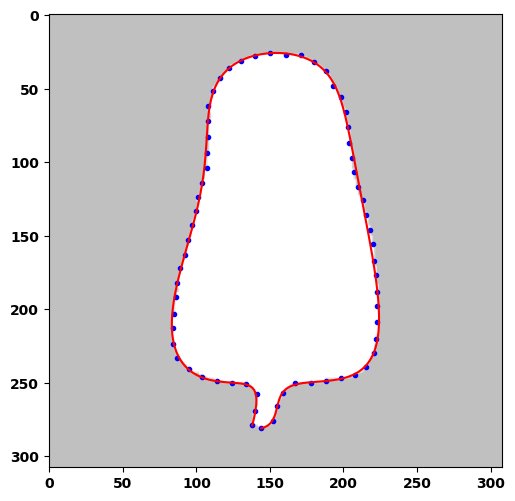

In [50]:
testOF1(imgn=6,N=11,err_th=0.5,of_th=0.5)

^^^^^^^^^^^.^..^.^..^.
CP 5.0, steps:21, etime: 9.46158 err: 4.6198335672
^^.^..........................................................................
......................................................................^^^^^^^.^.^...................
....................^^^^^^^^^.^.
CP 2.0, steps:231, etime: 54.05128 err: 1.9869303667
.................................^^^^^^^^.^.^.^..^..................
..............^^^^^^^^^^^^.^....^..................................^^^^^^^^^^^^^^^.^..^.............
.^^^^^^^^^..^^...............^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^.........................^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.......^...^.^^^^^^^^^^^^^^^^^^.^^^.^.^.^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.^^^^^^.^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1.0219889768878594, array([ 2, 63]))

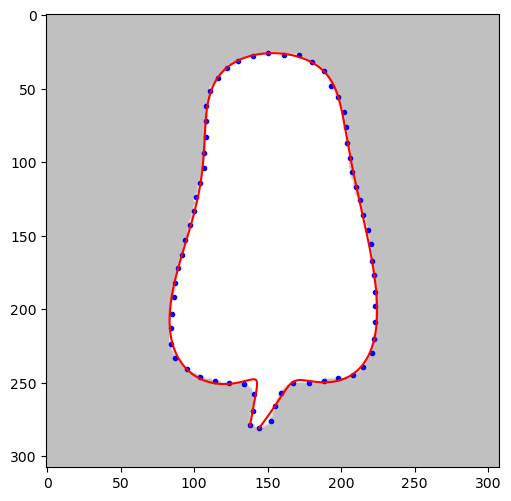

In [45]:
testOF(imgn=6,N=11,mode=0,err_th=0.5,of_th=0.5)

..
CP 5.0, steps:1, etime: 8.00000 err: 4.0651379678
.....................................
CP 2.0, steps:38, etime: 74.65625 err: 1.9913486850
.............................................................
...................................................................................
CP 1.0, steps:182, etime: 333.64062 err: 0.9985657736
.................
....................................................................................................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^..........................................^^^^^^^^^^....
.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............................^^^^^^^^^^^^^^^....
......................................................................................^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^....................................................................................
.................................

(3167, 0.6499944880274308, array([], dtype=int64))

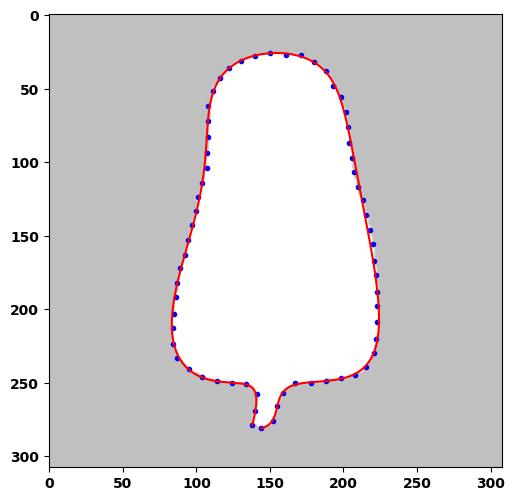

In [23]:
testOF1(imgn=6,N=11,err_th=0.65,of_th=0.65)

..
CP 5.0, steps:1, etime: 8.82353 err: 4.0651379701
.....................................
CP 2.0, steps:38, etime: 82.01568 err: 1.9913486845
.............................................................
...................................................................................E

[] [array([2.56329318, 2.5132994 , 3.94331828])]


(0.9985657733877532, array([], dtype=int64))

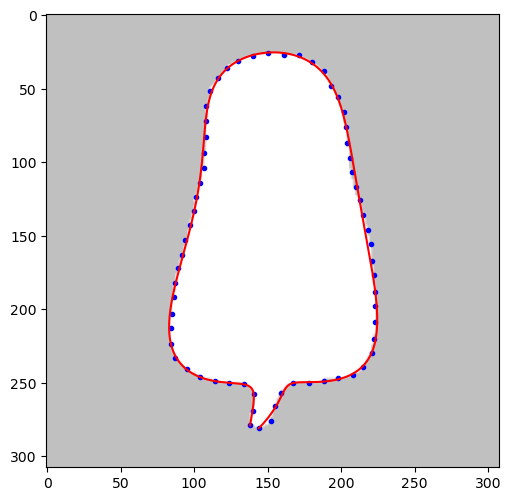

In [39]:
testOF1(imgn=6,N=11,err_th=1,of_th=1)

.
CP 5.0, steps:0, etime: 6.76562 err: 3.2096992802
......................
CP 2.0, steps:22, etime: 53.07812 err: 1.9841783970
..............................................................
CP 1.0, steps:84, etime: 182.04688 err: 0.9979369283
...............
......................................................................................
CP 0.65, steps:185, etime: 392.54688 err: 0.6498399430
..............
.....................^......^^......^^......^^^......^^^......^^^......^^^......^^^......^^^^.......
..^^.............^^^....................................^^^^^.....^^^..^^^...^^^^^^^^^..............
................................................................^...^^^^^^^^^^^....................^
^^^^^^^^^^................^^^^^^^^........................^^^^^.....................................
....................................................................................................
...............................................................................

(3585, 0.5150059837532924, array([], dtype=int64))

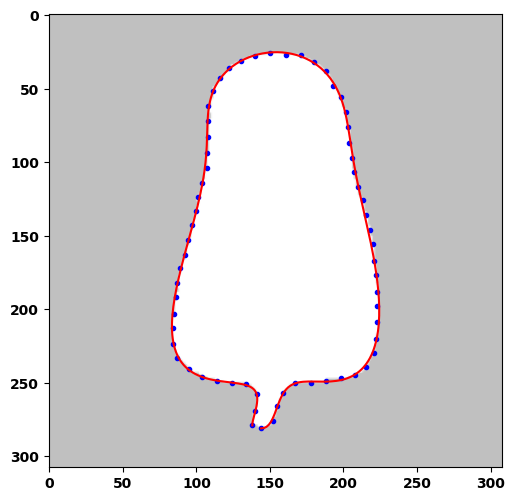

In [25]:
testOF1(imgn=6,N=12,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 7.24069 err: 3.2096992822
......................
CP 2.0, steps:22, etime: 57.26862 err: 1.9841783968
..............................................................
CP 1.0, steps:84, etime: 199.13365 err: 0.9979369283
...............
......................................................................................
CP 0.65, steps:185, etime: 432.78227 err: 0.6498399430
..............
.....................^......^^......^^......^^^......^^^......^^^......^^^......^^^......^^^^.......
..^^.............^^^....................................^^^^^.....^^^..^^^...^^^^^^^^^..............
................................................................^...^^^^^^^^^^^....................^
^^^^^^^^^^................^^^^^^^^........................^^^^^.....................................
....................................................................................................
...............................................................................

(0.515005983743691, array([], dtype=int64))

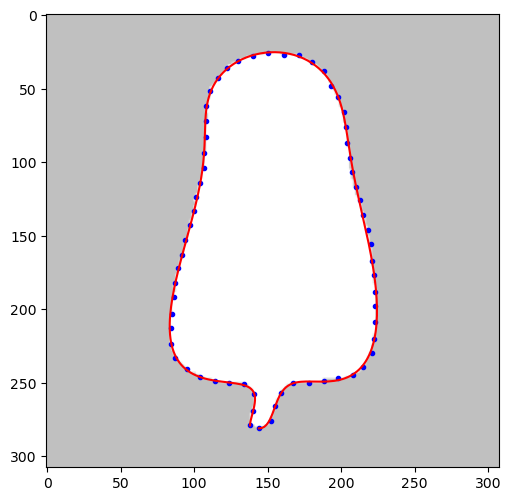

In [43]:
testOF1(imgn=6,N=12,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.87500 err: 3.2096992802
......................
CP 2.0, steps:22, etime: 53.17188 err: 1.9841783970
..............................................................
CP 1.0, steps:84, etime: 183.90625 err: 0.9979369283
...............
......................................................................................E

[] [array([1.93615768, 2.30449001])]


(185, 0.6498399430007685, array([], dtype=int64))

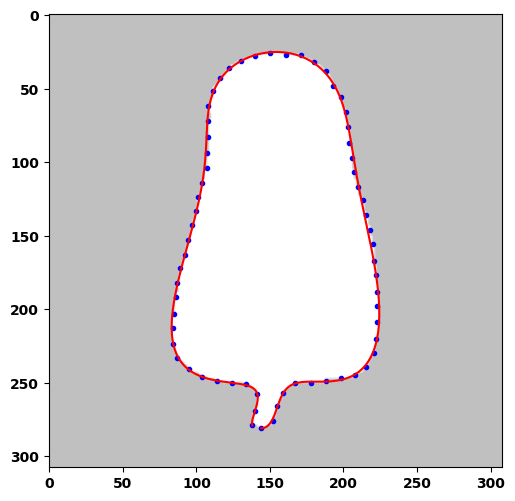

In [24]:
testOF1(imgn=6,N=12,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 7.87853 err: 2.9803392190
.......
CP 2.0, steps:7, etime: 26.00157 err: 1.9651303947
...................................................................
CP 1.0, steps:74, etime: 201.15667 err: 0.9999698919
.........................
.......................................................^............................................
........^.....^.....^....
CP 0.65, steps:224, etime: 589.26922 err: 0.6491346093
..^......^...^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^.........^......^....^.....^.
.....^.....^......^^.....^^....^^.....^^^...^^^....^^^...^^^^...^^^...^^^...^^^^...^^^...^^^...^^^..
.^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^^..^^^^..^^^^..^^^^..^^^^...^^^^..^^
^^..^^^^...^^^^..^^^^...^^^^..^^^^...^^^^..^^^..^^^^...^^^^...^^^^...^^^^...^^^^...^^^^...^^^^^..^^^
^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^..^^^..^^^..^^^..^^^..^^^..^^^...^^^^^..^^^.
.^^^^..^^^^^^.^^^...^^^^^^.^^^^..^^^^^^.^^^^..^^^^^^.^^^^..^^^^.^^^^..^^^^..^^^^

(0.5647125790186712, array([], dtype=int64))

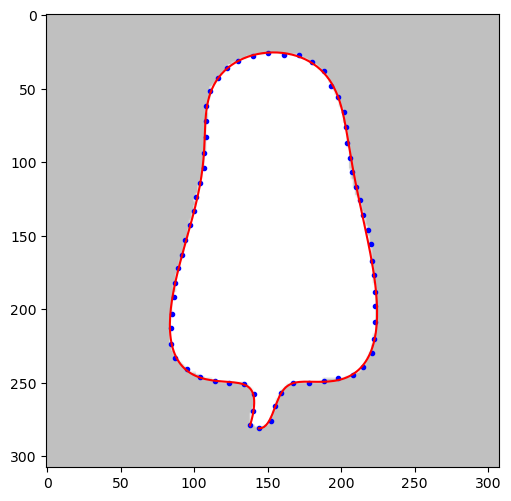

In [44]:
testOF1(imgn=6,N=13,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 7.20312 err: 2.9803392170
.......
CP 2.0, steps:7, etime: 23.70312 err: 1.9651303949
...................................................................
CP 1.0, steps:74, etime: 182.43750 err: 0.9999698920
.........................
.......................................................^............................................
........^.....^.....^....
CP 0.65, steps:224, etime: 535.95312 err: 0.6491346092
..^......^...^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^.........^......^....^.....^.
.....^.....^......^^.....^^....^^.....^^^...^^^....^^^...^^^^...^^^...^^^...^^^^...^^^...^^^...^^^..
.^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^^..^^^^..^^^^..^^^^..^^^^...^^^^..^^
^^..^^^^...^^^^..^^^^...^^^^..^^^^...^^^^..^^^..^^^^...^^^^...^^^^...^^^^...^^^^...^^^^...^^^^^..^^^
^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^..^^^..^^^..^^^..^^^..^^^..^^^...^^^^^..^^^.
.^^^^..^^^^^^.^^^...^^^^^^.^^^^..^^^^^^.^^^^..^^^^^^.^^^^..^^^^.^^^^..^^^^..^^^^

(2916, 0.5647125790046945, array([], dtype=int64))

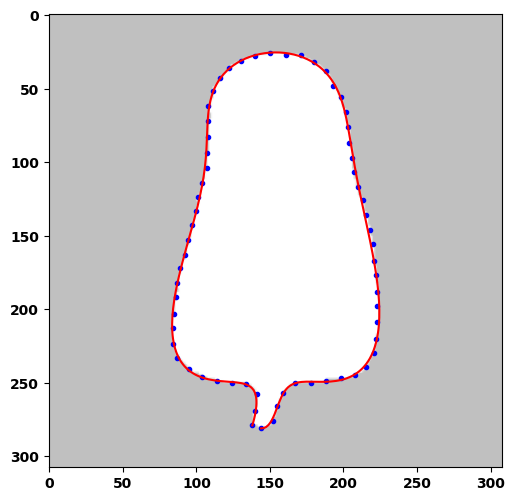

In [26]:
testOF1(imgn=6,N=13,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 8.20312 err: 2.6705587193
.....
CP 2.0, steps:5, etime: 22.31250 err: 1.9678813127
................................................
CP 1.0, steps:53, etime: 157.09375 err: 0.9892635274
..............................................
.....
CP 0.65, steps:104, etime: 298.07812 err: 0.6482836909
...............................................................................................
.............................................E

[] [array([2.27995501, 2.17302068])]


(244, 0.4999401059074423, array([], dtype=int64))

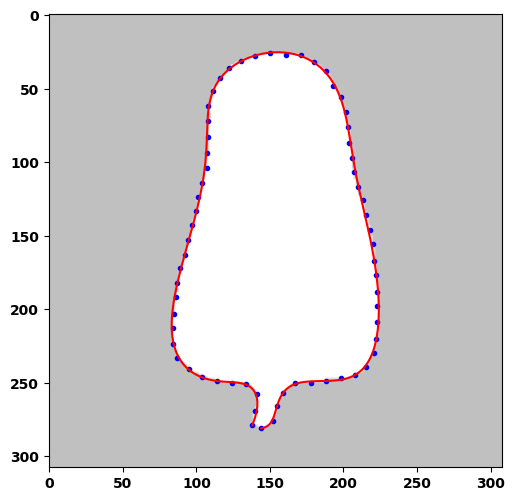

In [27]:
testOF1(imgn=6,N=14,err_th=0.5,of_th=0.5)

## img 7

....................................................................................................
...............................................
CP 5.0, steps:146, etime: 84.35938 err: 4.9972551644
.....................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................^.......................................................
.....................................

(2.176482634189293, array([], dtype=int64))

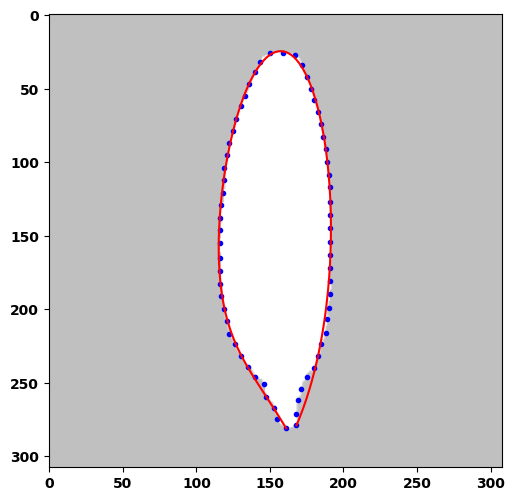

In [90]:
testOF1(imgn=7,N=5,err_th=1,of_th=1)

..
CP 5.0, steps:1, etime: 3.28125 err: 3.8464847931
..
CP 2.0, steps:3, etime: 4.73438 err: 1.7944055090
................................................................................................
........................................................................E

span 9.125302076339722
[] [array([2.3216394 , 2.49718223, 3.11919038])]


(0.9995540570696808, array([], dtype=int64))

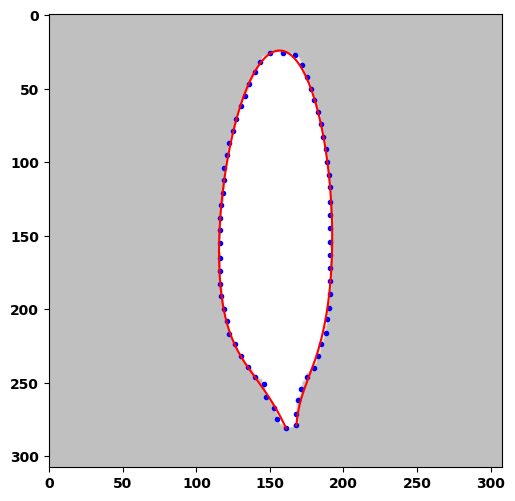

In [89]:
testOF1(imgn=7,N=6,err_th=1,of_th=1)

..
CP 5.0, steps:1, etime: 5.60938 err: 4.1362958246
.....
CP 2.0, steps:6, etime: 11.21875 err: 1.8958902078
................
CP 1.0, steps:22, etime: 29.00000 err: 0.9813704810
.............................................................................
.................^^^^^^^^^^^^^^^^^^..................
CP 0.65, steps:152, etime: 175.84375 err: 0.6499104335
...............................................
....................................................................................................
..................................^^^^^^^^^.^^^^^.^^^^.^^^^..^^^^^.^^^..^^^..^^^^..^^^^..^^^^..^^^^.
.^^^^^..^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^^..^^^^^..^^^^^..^^^^^^..^^^^^..^^^^^^.
.^^^^^..^^^^^^^.^^^^^..^^^^^^^.^^^^^..^^^^^^^.^^^^^..^^^^^^^.^^^^^..^^^^^^^.^^^^^..^^^^^^^.^^^^^..^^
^^^^^.^^^^^..^^^^^^^.^^^^^^^.^^^^^..^^^^^^^.^^^^^..^^^^^^^.^^^^^^^.^^^^^..^^^^^^^.^^^^^^^.^^^^^..^^^
^^^^.^^^^^^^.^^^^^..^^^^^^^.^^^^^^^.^^^^^..^^^^^^^.^^^^^^^.^^^^^..^^^^^^^.^^^^^^^

(5758, 0.6024058954825423, array([], dtype=int64))

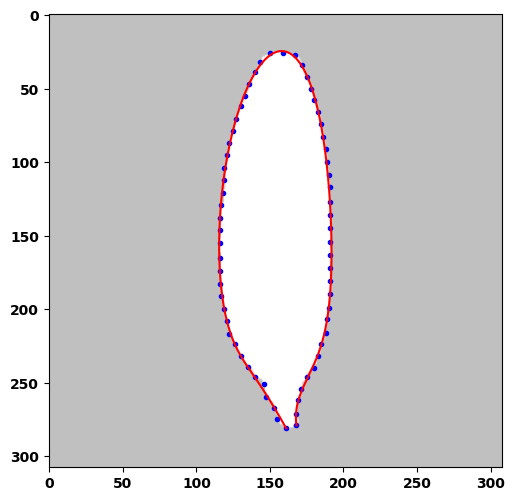

In [41]:
testOF1(imgn=7,N=8,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 5.53125 err: 4.0799340508
..
CP 2.0, steps:2, etime: 8.21875 err: 1.3824909631
..
CP 1.0, steps:4, etime: 10.89062 err: 0.9691390607
...............................................................................................
............
CP 0.65, steps:111, etime: 154.35938 err: 0.6499750672
........................................................................................
....................................................................................................
..................C

[] [array([1.42889158, 1.7074163 , 3.7704815 , 3.21115429, 1.76434854,
       2.19861367])]


(317, 0.6363810634419503, array([], dtype=int64))

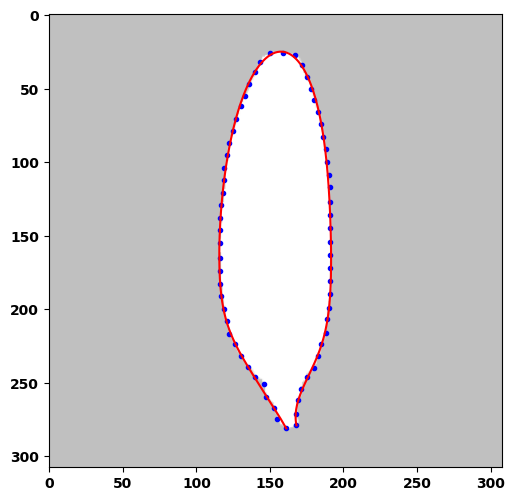

In [42]:
testOF1(imgn=7,N=9,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.06250 err: 2.7351658624
.
CP 2.0, steps:1, etime: 7.65625 err: 1.7949229362
.......
CP 1.0, steps:8, etime: 18.96875 err: 0.9900650823
...........................................................................................
..
CP 0.65, steps:101, etime: 169.82812 err: 0.6498854977
..................................................................................................
....................................................................................................
..................................C

[] [array([2.36489181, 3.71442039, 3.29998077, 2.25146911, 2.66975072])]


(333, 0.6342393986500524, array([], dtype=int64))

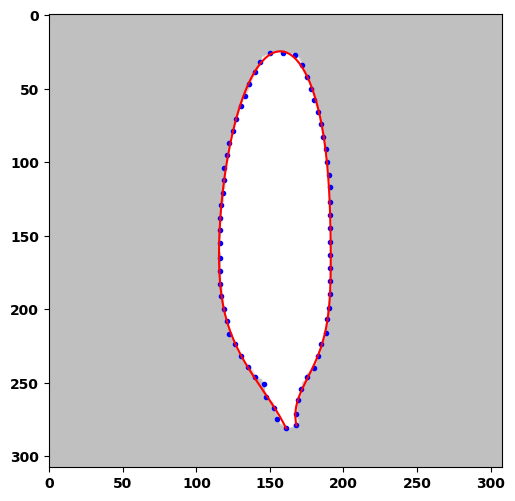

In [39]:
testOF1(imgn=7,N=10,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.12653 err: 2.7351658762
.
CP 2.0, steps:1, etime: 7.77876 err: 1.7949229412
.......
CP 1.0, steps:8, etime: 19.37966 err: 0.9900650831
...........................................................................................
..
CP 0.65, steps:101, etime: 173.09280 err: 0.6498854979
..................................................................................................
....................................................................................................
..................................C

[] [array([2.3648918 , 3.7144204 , 3.29998077, 2.25146911, 2.66975072])]


(0.6342393986675591, array([], dtype=int64))

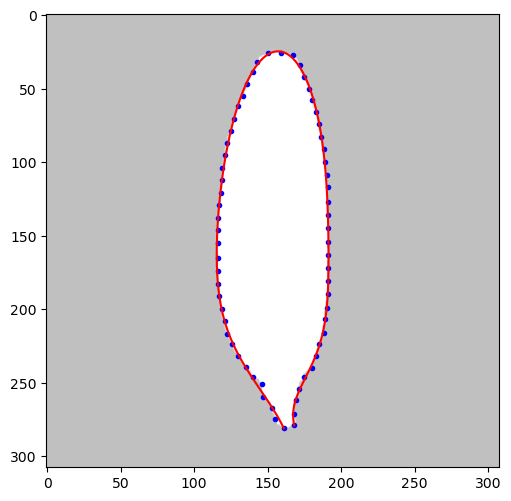

In [38]:
testOF1(imgn=7,N=10,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.68750 err: 1.8113496043
.
CP 2.0, steps:1, etime: 8.57812 err: 1.1516095756
.
CP 1.0, steps:2, etime: 10.46875 err: 0.9145330647
........
CP 0.65, steps:10, etime: 25.68750 err: 0.6416454546
.....^........................................................^^^^^^^..^^^^^...^^^^^^....E

[] [array([1.37988097, 1.45016189, 2.81429095, 2.17824452, 1.43299826])]


(99, 0.4993758890192707, array([], dtype=int64))

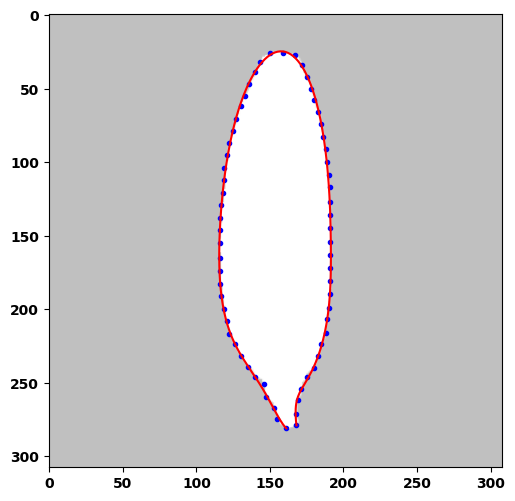

In [38]:
testOF1(imgn=7,N=11,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.79552 err: 1.8113496123
.
CP 2.0, steps:1, etime: 8.74431 err: 1.1516095776
.
CP 1.0, steps:2, etime: 10.69674 err: 0.9145330648
........
CP 0.65, steps:10, etime: 26.18527 err: 0.6416454536
.....^........................................................^^^^^^^..^^^^^...^^^^^^....E

[] [array([1.37988097, 1.45016189, 2.81429095, 2.17824451, 1.43299826])]


(0.4993758883413737, array([], dtype=int64))

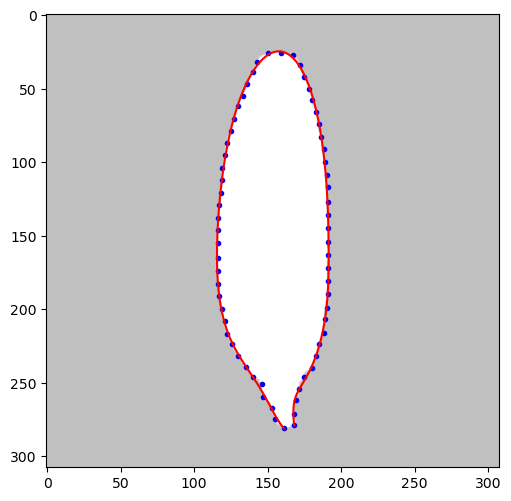

In [37]:
testOF1(imgn=7,N=11,err_th=0.5,of_th=0.5)


## img 8

....
CP 5.0, steps:3, etime: 6.23438 err: 4.8074294956
................................................................................................
....................................................................................................
....................................................................................................
............^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.
^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^..C

[] [array([7.26124684, 4.64399985, 6.96748282, 6.86484103, 5.16729798,
       3.70755815])]


(498, 3.164528542932713, array([], dtype=int64))

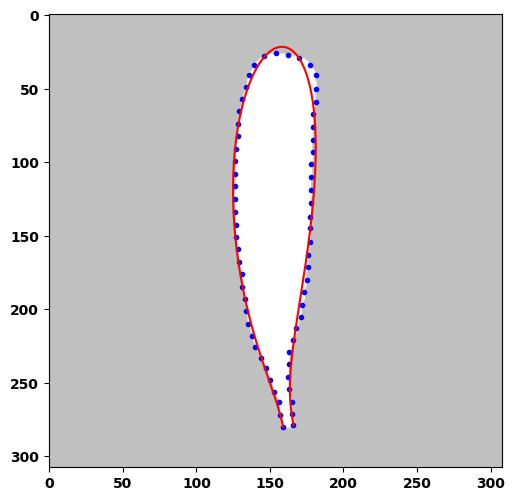

In [45]:
testOF1(imgn=8,N=7,err_th=1,of_th=1)

.............
CP 5.0, steps:12, etime: 18.80237 err: 4.9431393901
......................................................................................
CP 2.0, steps:98, etime: 119.76427 err: 1.9971274217
.
.........................................................^^^^^^^.....^^^^^^^^^^^^^^^^..........^^^..
...................^^............^.............^...........^.........^...........^.......^^.........
.....^.....................^.......^.......^.......^...............^.......^^^...............^......
.^.......^.......^.........^.......^.....^^^...........^^^.........^...^.....^...........^.....^....
.....^.......^.......^.....^.....^..................................................................
.............
CP 1.0, steps:612, etime: 728.80432 err: 0.9983868890
.......................................................................................
.................................................................................................^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6834728692631932, array([], dtype=int64))

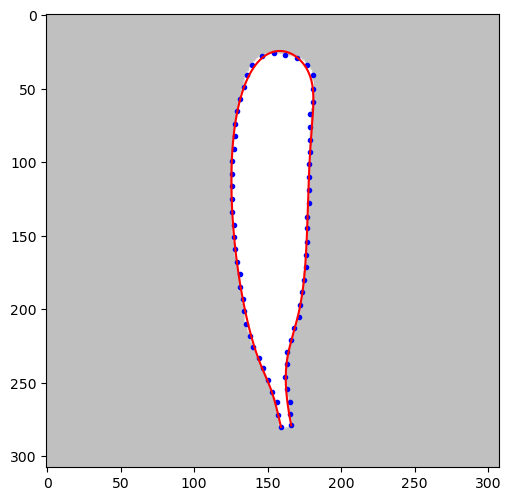

In [42]:
testOF1(imgn=8,N=8,err_th=0.5,of_th=0.5)

.............
CP 5.0, steps:12, etime: 18.18750 err: 4.9431393901
......................................................................................
CP 2.0, steps:98, etime: 115.39062 err: 1.9971274217
.
.........................................................^^^^^^^.....^^^^^^^^^^^^^^^^..........^^^..
...................^^............^.............^...........^.........^...........^.......^^.........
.....^.....................^.......^.......^.......^...............^.......^^^...............^......
.^.......^.......^.........^.......^.....^^^...........^^^.........^...^.....^...........^.....^....
.....^.......^.......^.....^.....^..................................................................
.............E

[] [array([2.80901572, 2.06955597, 1.72469076, 2.73061324, 2.2996128 ,
       1.55266755])]


(612, 0.9983868890218102, array([], dtype=int64))

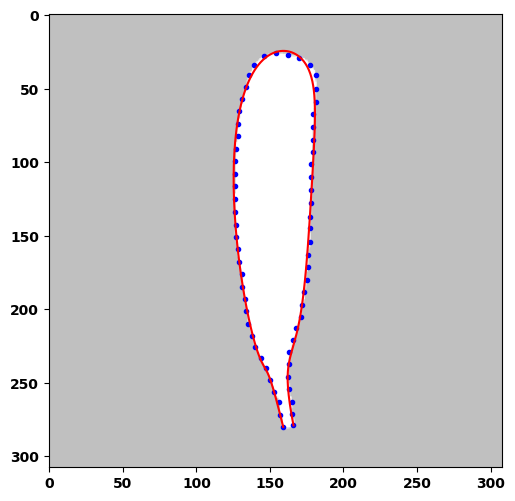

In [44]:
testOF1(imgn=8,N=8,err_th=1,of_th=1)

..
CP 5.0, steps:1, etime: 6.84375 err: 4.2995753669
...................................................................
CP 2.0, steps:68, etime: 96.54688 err: 1.9913757519
...............................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................E

[] [array([3.14776719, 2.11226508, 2.21643629, 3.27533926, 2.43570746])]


(462, 0.9988062474486236, array([], dtype=int64))

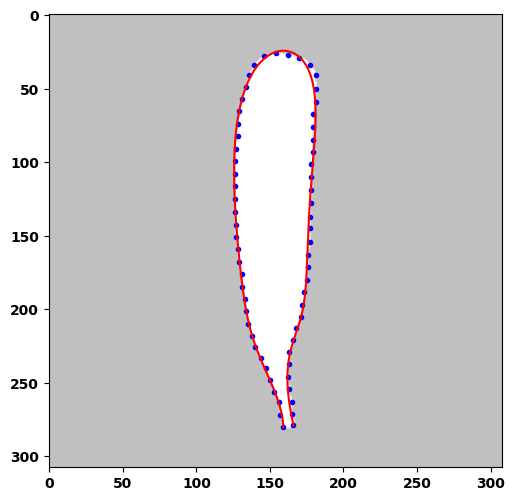

In [43]:
testOF1(imgn=8,N=9,err_th=1,of_th=1)

..
CP 5.0, steps:1, etime: 6.85938 err: 4.2995753669
...................................................................
CP 2.0, steps:68, etime: 98.37500 err: 1.9913757519
...............................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................
CP 1.0, steps:462, etime: 656.39062 err: 0.9988062474
.....................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................

(0.5853402125024889, array([], dtype=int64))

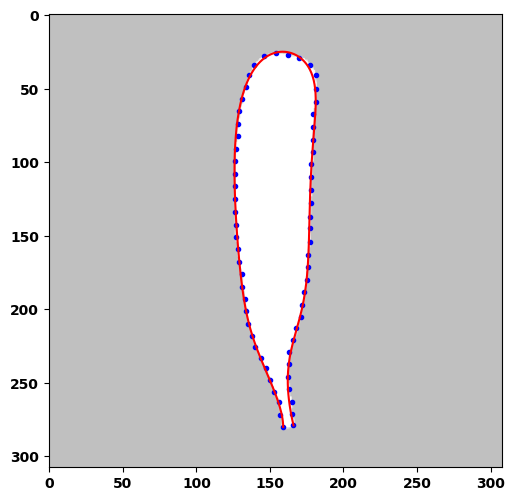

In [91]:
testOF1(imgn=8,N=9,err_th=0.5,of_th=0.5)

...........
CP 5.0, steps:10, etime: 21.79688 err: 4.8920677147
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................^.............................................
....................................................................................................
............................................................................
CP 2.0, steps:675, etime: 1095.92188 err: 1.9998927883
........................
.....................................................^^^....^^^^....^^^^^.......^...................
...................................................................................

(0.8717743033331482, array([], dtype=int64))

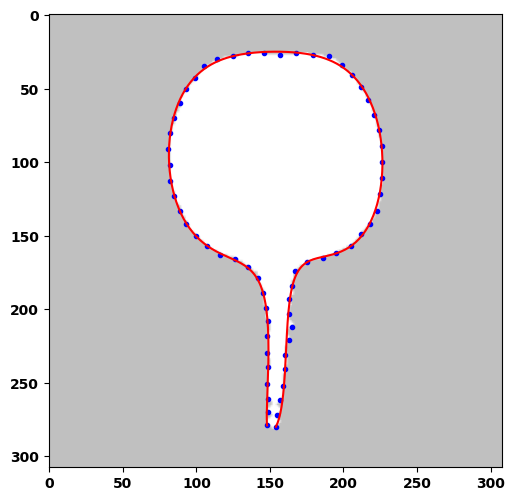

In [77]:
testOF1(imgn=4,N=10,err_th=0.65,of_th=0.65)

^^^^^^^^^.^.^^.^.^..^................................
CP 5.0, steps:52, etime: 14.57812 err: 4.9777140652
...............................................
.....................^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.....................................................^^^^^^^^....................^^^^^^^^^
^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1903, 391.109375, 2.047797768171831, array([], dtype=int64))

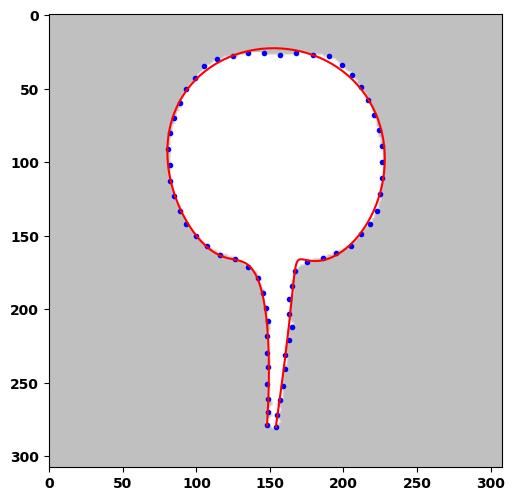

In [8]:
testOF(imgn=4,N=10,mode=0,err_th=2.0,of_th=2.0)

........
CP 5.0, steps:7, etime: 12.53125 err: 4.9252023902
............................................................................................
.................................
CP 2.0, steps:132, etime: 141.73438 err: 1.9981042466
...................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................
CP 1.0, steps:657, etime: 674.10938 err: 0.9990928137
..........................................
....................................................................................................
..............................

(3000, 3070.40625, 0.5571677514591203, array([], dtype=int64))

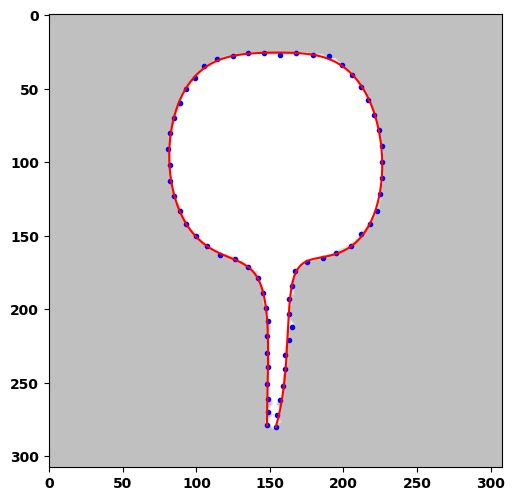

In [11]:
testOF(imgn=4,N=10,mode=1,err_th=0.5,of_th=0.5)

.......
CP 5.0, steps:6, etime: 12.87500 err: 4.9715167777
..........................................
CP 2.0, steps:48, etime: 64.15625 err: 1.9872839437
...................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................................
CP 1.0, steps:497, etime: 618.35938 err: 0.9972565804
..
....................................................................................................
..................................
CP 0.65, steps:633, etime: 787.04688 err: 0.6474517078
..................................................................
...................E
[] [array([3.35784219, 3.05712049])] (array([56, 63], dt

(718, 890.3125, 0.49964983793402257, array([], dtype=int64))

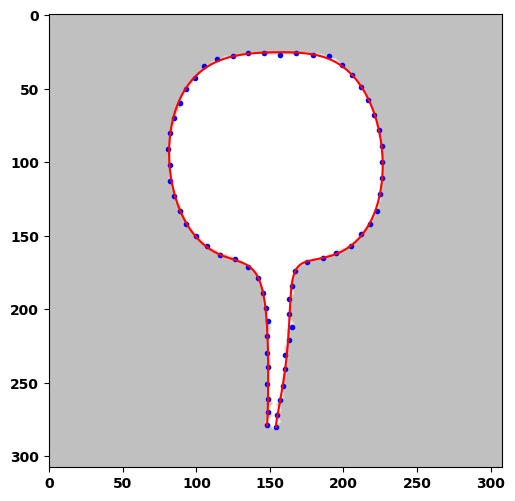

In [12]:
testOF(imgn=4,N=11,mode=1,err_th=0.5,of_th=0.5)

.........
CP 5.0, steps:8, etime: 21.79688 err: 4.9612035157
...........................................................................................
...........................^^^^^^^^^................................................................
...........
CP 2.0, steps:210, etime: 397.78125 err: 1.9994923920
.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................
CP 1.0, steps:842, etime: 1592.51562 err:

(0.6498108162416761, array([], dtype=int64))

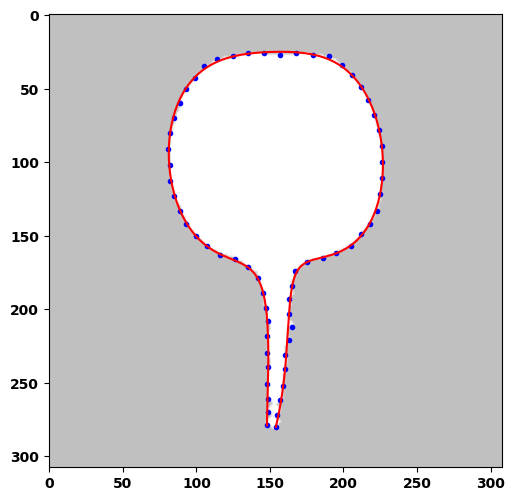

In [75]:
testOF1(imgn=4,N=11,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 6.03125 err: 4.9466902667
.....
CP 2.0, steps:5, etime: 13.23438 err: 1.9356079937
............
CP 1.0, steps:17, etime: 30.45312 err: 0.9956731634
..................................................................................
....................................................................................................
.............................................................................................
CP 0.65, steps:292, etime: 427.39062 err: 0.6497188431
.......
....................................................................................................
......................^^^^^^^^^^^^^^^^^.............................................................
...................................................................................E
[63] [array([4.87617071, 2.45393811, 7.02725945])] (array([56, 57, 63], dtype=int64),) span 11.328348133713007


(582, 855.453125, 0.49985968008972526, array([63], dtype=int64))

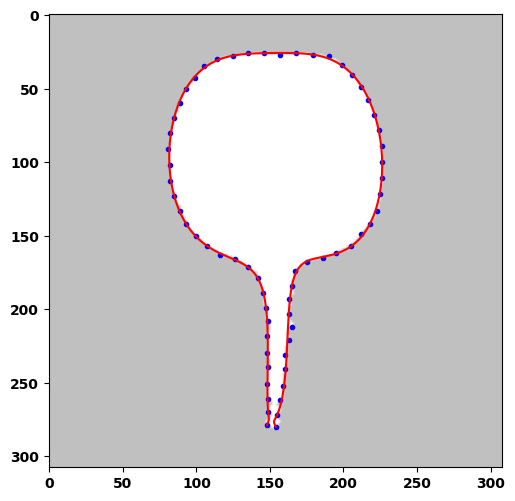

In [13]:
testOF(imgn=4,N=12,mode=1,err_th=0.5,of_th=0.5)

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.26562 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 106.85938 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............
CP 1.0, steps:572, etime: 152.76562 err: 0.9983760091
..^^..................^^^^^
^^^^^^^^^^^^^^^^^...........^.^^^^^^^^^^^^^^^.^.^.^..^^^^^^^^^^^^^^^^^^^^^^..
CP 0.65, steps:676, etime: 180.17188 err: 0.6429531236
.......................
..........^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......E
[] [array([3.36612793, 3.

(747, 198.484375, 0.49712800549062075, array([], dtype=int64))

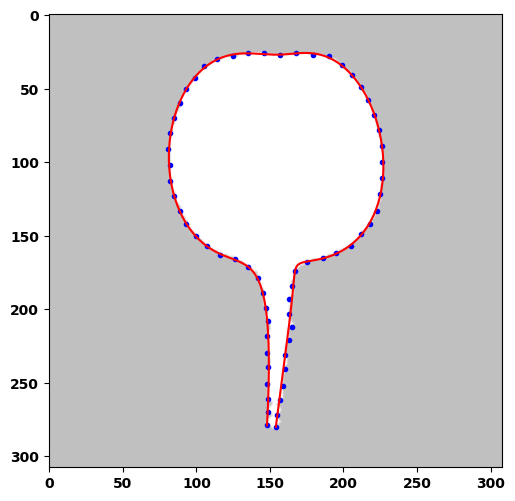

In [10]:
testOF(imgn=4,N=12,mode=0,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.75000 err: 4.1975619296
......
CP 2.0, steps:6, etime: 19.50000 err: 1.8522259930
..................................................
CP 1.0, steps:56, etime: 124.06250 err: 0.9994330342
...........................................
...^................................................................................................
....................................................................................................
....................................................................................................
....................^^..............................................................................
..^......^^^.....^^^^....^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^...^^^^^^^^^..^^^^^^^
^.^^^^.^^^^.^^^^^.^^^^^^^^^^..^^^^^^^^^.^^^^^.^^^^^.^^^^^^.^^^^^^.^^^^^^.^^^^^^^^^^^^^.^^^^^^^.^^^^^
^^.^^^^^^^.^^^^^^^^.^^^^^^^^^^^^^^^^..^^^^^^^^^.^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^....^^^^^^^
^^^^^.^^^^^^^^^^^^^.^^^^^^^^^^^^^.^

(0.6843336195663922, array([56, 62], dtype=int64))

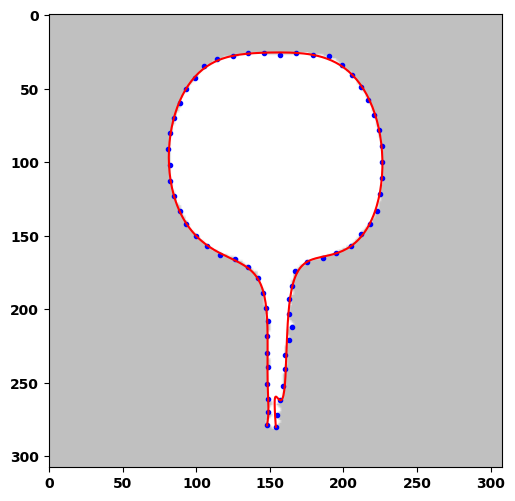

In [94]:
testOF1(imgn=4,N=12,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.71875 err: 4.1975619296
......
CP 2.0, steps:6, etime: 19.26562 err: 1.8522259930
..................................................E

[] [array([2.34591631, 2.54063656, 2.97187059, 5.7108673 , 3.06243689,
       3.64017051, 4.19527819])] (array([32, 34, 35, 56, 57, 62, 63], dtype=int64),) span 11.328348133713007


(56, 122.390625, 0.9994330341753543, array([], dtype=int64))

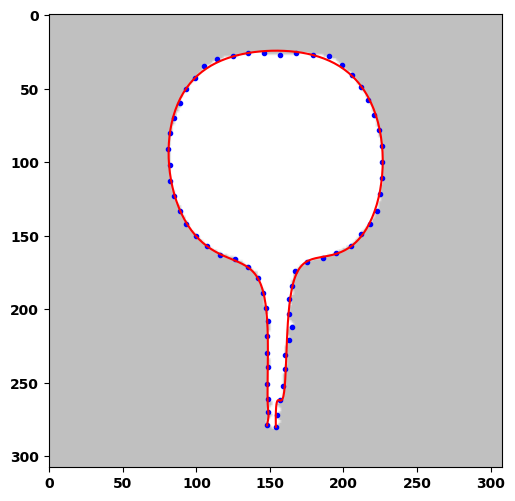

In [29]:
testOF1(imgn=4,N=12,err_th=1,of_th=1)

## rad5

...........
CP 5.0, steps:10, etime: 14.98438 err: 4.8771531805
.........................................................................................
..............................................
CP 2.0, steps:145, etime: 162.29688 err: 1.9954261278
......................................................
.......^.......................^.......^......^......^.......^......^......^.......^......^......^..
.....^......^^.....^^^^....^^.....^^.....^^.....^^......^^......^^......^^......^^^.....^^^.....^^^.
....^^^.....^^^.....^^^.....^^^....^^^....^^^....^^^....^^^....^^^...^^^^^..........................
.............................................................................................^^.....
.....
CP 1.0, steps:604, etime: 673.57812 err: 0.9999983801
.......^^............^^..........^^........^^.......^^.......^^......^^......^^.....^^.....^^..
..^^.....^^....^^....^^....^^^....^^...^^...^^^....^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^
^^...^^^..^^^...^^^...^^^^...

(0.9007567016916533, array([], dtype=int64))

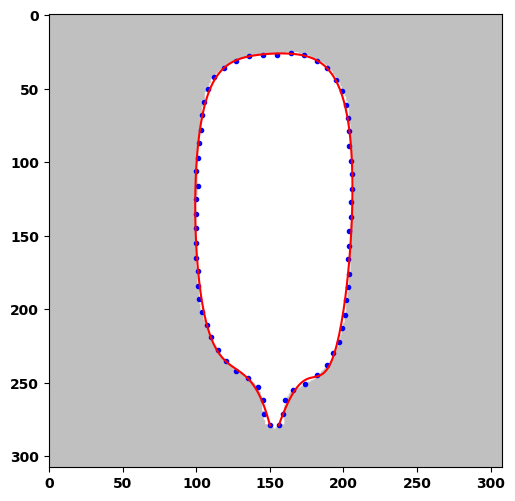

In [78]:
testOF1(imgn=5,N=8,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 5.48438 err: 3.5331180744
............................
CP 2.0, steps:28, etime: 43.53125 err: 1.9969662237
.......................................................................
....................................................................................................
.................
CP 1.0, steps:216, etime: 299.42188 err: 0.9987704707
...................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................E



(0.6498962468744777, array([], dtype=int64))

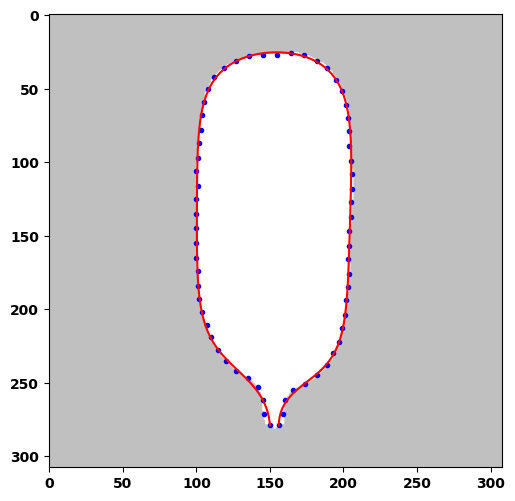

In [79]:
testOF1(imgn=5,N=9,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 5.57812 err: 3.5331180744
............................
CP 2.0, steps:28, etime: 42.68750 err: 1.9969662237
.......................................................................
....................................................................................................
.................
CP 1.0, steps:216, etime: 295.31250 err: 0.9987704707
...................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................
CP 0.65, steps:664, etime: 896.37500 err: 0.6498962469
...................................
..............................................................................

(0.631513604825175, array([], dtype=int64))

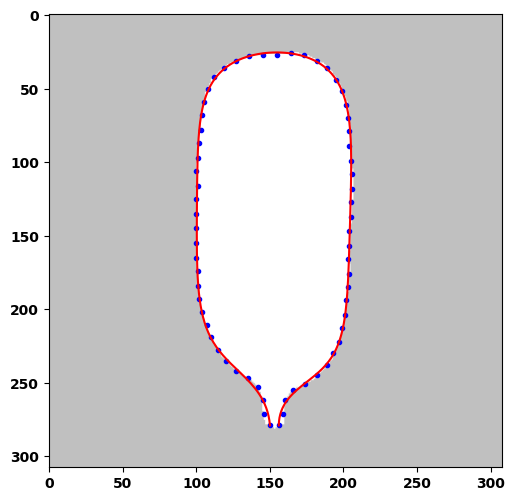

In [6]:
testOF1(imgn=5,N=9,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 5.64062 err: 3.5331180744
............................
CP 2.0, steps:28, etime: 43.12500 err: 1.9969662237
.......................................................................
....................................................................................................
.................
CP 1.0, steps:216, etime: 293.12500 err: 0.9987704707
...................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................
CP 0.65, steps:664, etime: 908.09375 err: 0.6498962469
...................................
..............................................................................

(0.631513604825175, array([], dtype=int64))

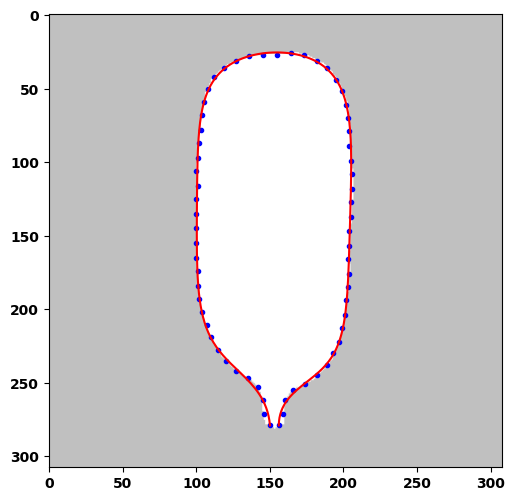

In [80]:
testOF1(imgn=5,N=9,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.00000 err: 3.8963761222
.................
CP 2.0, steps:17, etime: 32.51562 err: 1.9740036920
..................................................................................
......................................
CP 1.0, steps:137, etime: 223.17188 err: 0.9969124809
..............................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................

(0.6192815701835149, array([], dtype=int64))

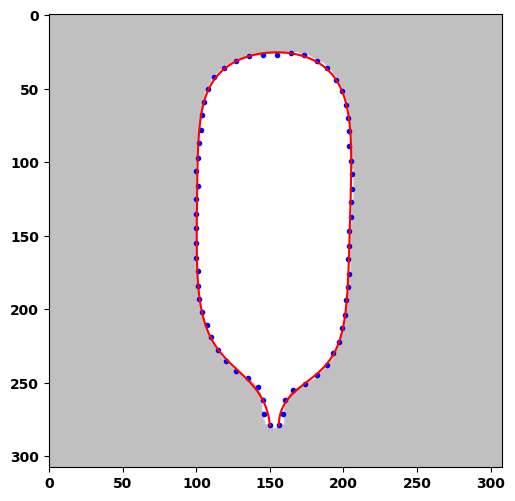

In [7]:
testOF1(imgn=5,N=10,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 5.96875 err: 3.8963761222
.................
CP 2.0, steps:17, etime: 33.31250 err: 1.9740036920
..................................................................................
......................................
CP 1.0, steps:137, etime: 228.23438 err: 0.9969124809
..............................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................

(0.6192815701835149, array([], dtype=int64))

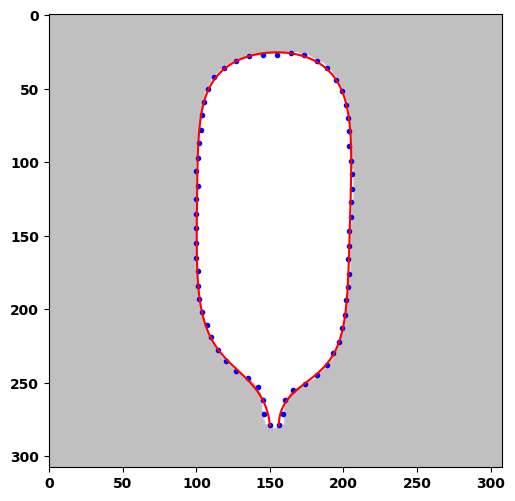

In [81]:
testOF1(imgn=5,N=10,err_th=0.5,of_th=0.5)

## rad6

.......................
CP 5.0, steps:22, etime: 40.60938 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 400.64062 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(0.9654089548899831, array([62, 63], dtype=int64))

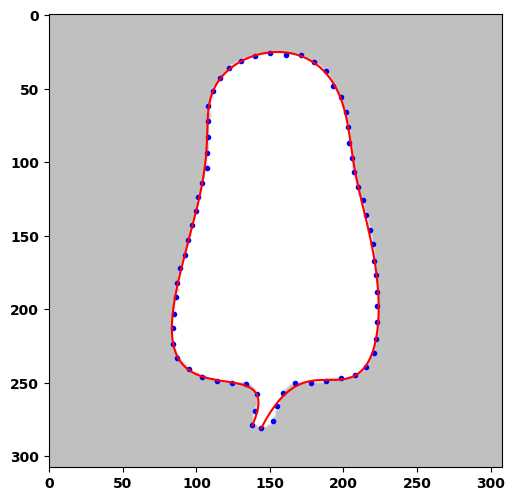

In [9]:
testOF1(imgn=6,N=10,err_th=0.5,of_th=0.5)

.......................
CP 5.0, steps:22, etime: 39.62500 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 391.06250 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(11817, 18565.8125, 0.9654089548899831, array([62, 63], dtype=int64))

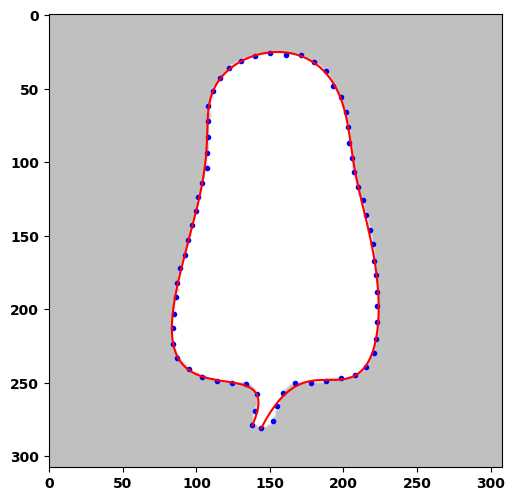

In [16]:
testOF1(imgn=6,N=10,err_th=0.5,of_th=0.5)

.......................
CP 5.0, steps:22, etime: 39.54688 err: 4.9504528677
.............................................................................
....................................................................................................
...................................................
CP 2.0, steps:250, etime: 390.81250 err: 1.9959237788
.................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................^^^^...................................................
....................................................................................................
....................................................................................

(3000, 4675.3125, 0.9716617753411919, array([], dtype=int64))

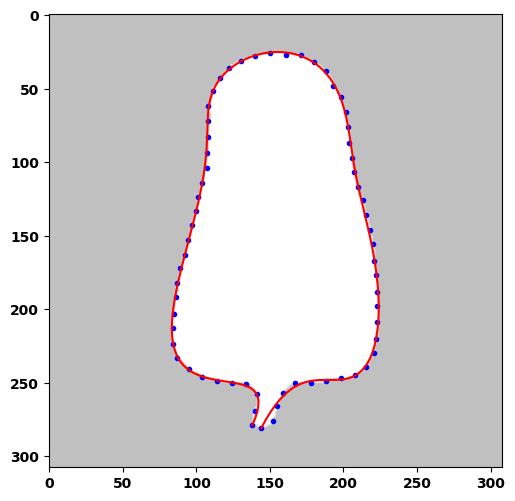

In [32]:
testOF1(imgn=6,N=10,err_th=0.9,of_th=0.9)

^^^^^e1.e1^.^.^..^.^.^^.^..^...................................................................
CP 5.0, steps:90, etime: 22.32812 err: 4.9955644639
.........
....................................................................................................
...................^^^^^^^^^^^^^...................................................^^^^^^^^^^^^.^...
..............................................^^^^^^^^^^^^^^........................................
...............^^^^^^^^^^^^^^.^................................................^^^^^^^^^^^^^^^^^.^.^
.^.^.^.^..^.^.^.^......................................^^^^^^^^^^^^^.^.^^^^^^.^.^.^.
CP 2.0, steps:583, etime: 122.10938 err: 1.9971751229
^.^.^^^^.^.^.^.^
.^^^^^^.^.^^^^^^^^^^^.^....^.^.^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^
.^.^.^^^^^^^^^^^^^^^.^.^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 633.21875, 1.1447108737806566, array([], dtype=int64))

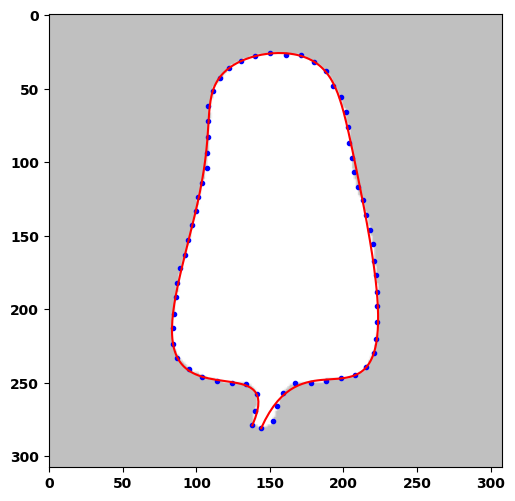

In [19]:
testOF(imgn=6,N=10,mode=0,err_th=1.0,of_th=1.0)

^^^^^e1.e1^.^.^..^.^.^^.^..^...................................................................
CP 5.0, steps:90, etime: 24.78125 err: 4.9955644639
.........
....................................................................................................
...................^^^^^^^^^^^^^...................................................^^^^^^^^^^^^.^...
..............................................^^^^^^^^^^^^^^........................................
...............^^^^^^^^^^^^^^.^................................................^^^^^^^^^^^^^^^^^.^.^
.^.^.^.^..^.^.^.^......................................^^^^^^^^^^^^^.^.^^^^^^.^.^.^.
CP 2.0, steps:583, etime: 129.50000 err: 1.9971751229
^.^.^^^^.^.^.^.^
.^^^^^^.^.^^^^^^^^^^^.^....^.^.^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^
.^.^.^^^^^^^^^^^^^^^.^.^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 622.078125, 1.1447108737806566, array([63], dtype=int64))

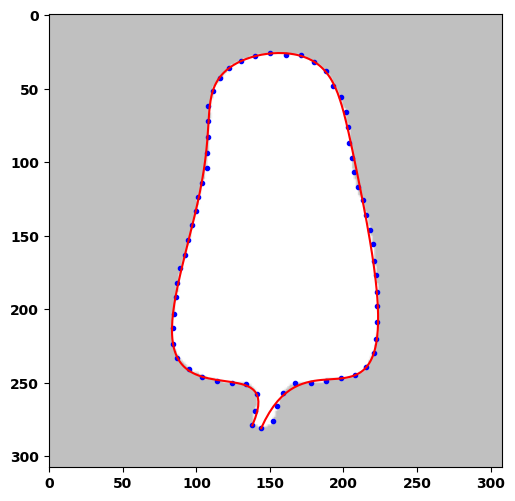

In [21]:
testOF(imgn=6,N=10,mode=0,err_th=0.65,of_th=0.65)

^^^^^^^^^^^.^..^.^..^.
CP 5.0, steps:21, etime: 9.68750 err: 4.6200057650
^^.^..........................................................................
.......................................................................^^^^^.^^...^.................
........................^^^^^^^^^.
CP 2.0, steps:233, etime: 60.75000 err: 1.9899104783
^........................................^^^^^^^^^^.^.^...........
..........................^^^^^^^^^^.^.^....^...............................^^^^^^^^.^^^^^^.^..^....
^^^^^^^^^^..^^......................^^^^^^^^^^^^^^^^^^^^^^^^....................^.^.^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^.^.^.^^^^^.^^^.^.....^.^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^.^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 693.671875, 1.0234006592188545, array([2], dtype=int64))

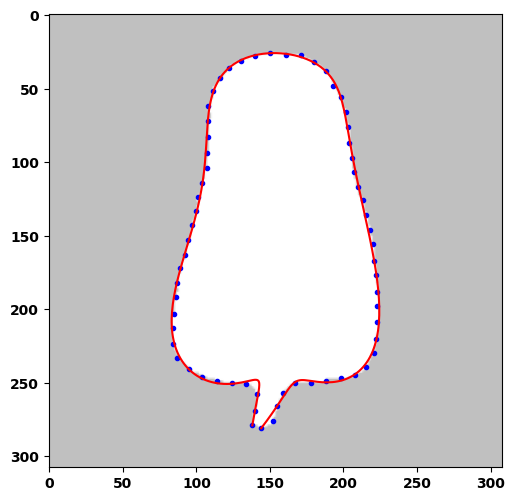

In [35]:
testOF(imgn=6,N=11,mode=0,err_th=1,of_th=1.0)

..
CP 5.0, steps:1, etime: 8.00000 err: 4.0651379678
.....................................
CP 2.0, steps:38, etime: 74.31250 err: 1.9913486850
.............................................................
...................................................................................
CP 1.0, steps:182, etime: 333.23438 err: 0.9985657736
.................
....................................................................................................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^..........................................^^^^^^^^^^....
.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............................^^^^^^^^^^^^^^^....
......................................................................................^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^....................................................................................
.................................

(3000, 5518.703125, 0.6510270057003524, array([], dtype=int64))

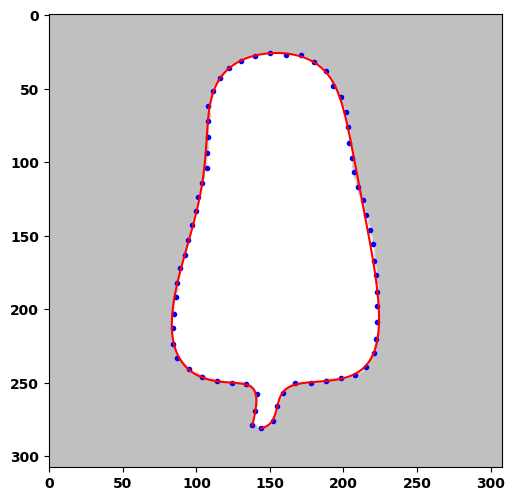

In [33]:
testOF1(imgn=6,N=11,err_th=0.65,of_th=0.65)

.
CP 5.0, steps:0, etime: 6.68750 err: 3.2096992802
......................
CP 2.0, steps:22, etime: 52.26562 err: 1.9841783970
..............................................................
CP 1.0, steps:84, etime: 181.29688 err: 0.9979369283
...............
......................................................................................
CP 0.65, steps:185, etime: 392.15625 err: 0.6498399430
..............
.....................^......^^......^^......^^^......^^^......^^^......^^^......^^^......^^^^.......
..^^.............^^^....................................^^^^^.....^^^..^^^...^^^^^^^^^..............
................................................................^...^^^^^^^^^^^....................^
^^^^^^^^^^................^^^^^^^^........................^^^^^.....................................
....................................................................................................
...............................................................................

(3000, 6338.03125, 0.515135070875229, array([], dtype=int64))

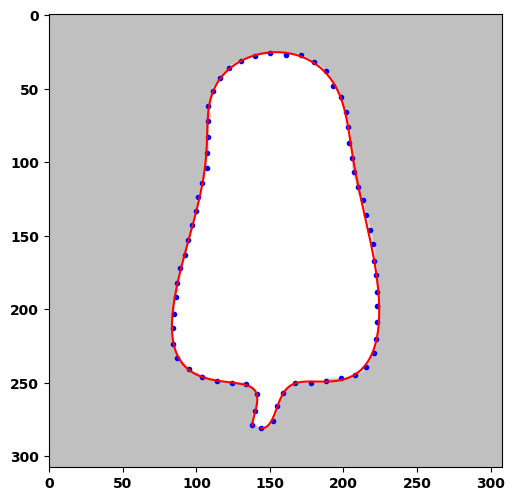

In [34]:
testOF1(imgn=6,N=12,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 8.23438 err: 2.6705587193
.....
CP 2.0, steps:5, etime: 22.17188 err: 1.9678813127
................................................
CP 1.0, steps:53, etime: 156.50000 err: 0.9892635274
..............................................
.....
CP 0.65, steps:104, etime: 298.98438 err: 0.6482836909
...............................................................................................
.............................................E

span 10.89222801849246
[] [array([2.27995501, 2.17302068])]


(0.4999401059074423, array([], dtype=int64))

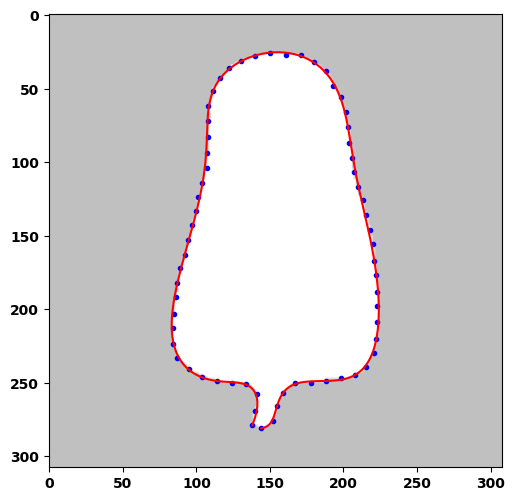

In [7]:
testOF1(imgn=6,N=14,err_th=0.5,of_th=0.5)

## rad7

## rad8

.............
CP 5.0, steps:12, etime: 17.03125 err: 4.9431393901
......................................................................................
CP 2.0, steps:98, etime: 107.76562 err: 1.9971274217
.
.........................................................^^^^^^^.....^^^^^^^^^^^^^^^^..........^^^..
...................^^............^.............^...........^.........^...........^.......^^.........
.....^.....................^.......^.......^.......^...............^.......^^^...............^......
.^.......^.......^.........^.......^.....^^^...........^^^.........^...^.....^...........^.....^....
.....^.......^.......^.....^.....^..................................................................
.............
CP 1.0, steps:612, etime: 670.76562 err: 0.9983868890
.......................................................................................
.................................................................................................^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 3268.9375, 0.6927915967135743, array([], dtype=int64))

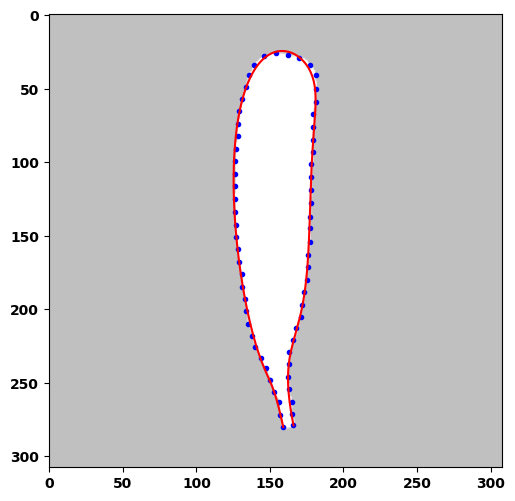

In [38]:
testOF1(imgn=8,N=8,err_th=0.5,of_th=0.5)

..
CP 5.0, steps:1, etime: 6.78125 err: 4.2995753669
...................................................................
CP 2.0, steps:68, etime: 93.53125 err: 1.9913757519
...............................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................
CP 1.0, steps:462, etime: 612.95312 err: 0.9988062474
.....................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................

(3000, 3957.6875, 0.5855739166625328, array([], dtype=int64))

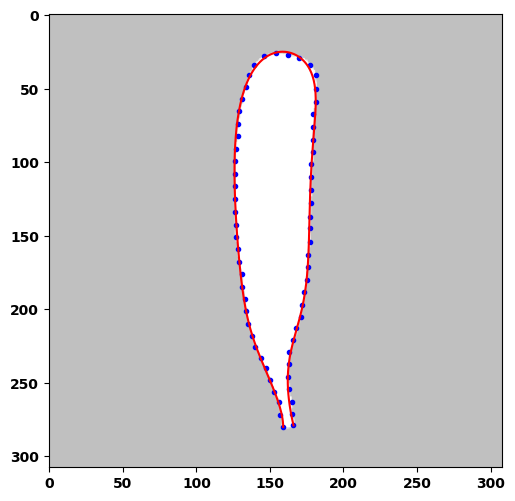

In [36]:
testOF1(imgn=8,N=9,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.53125 err: 2.5318124113
.
CP 2.0, steps:1, etime: 8.45312 err: 1.8297684793
........................................................................................
CP 1.0, steps:89, etime: 176.15625 err: 0.9976877879
..........
....................................................................................................
....................................................................................................
..............................................................................................
CP 0.65, steps:393, etime: 745.71875 err: 0.6497772381
......
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

(0.5149413362374975, array([], dtype=int64))

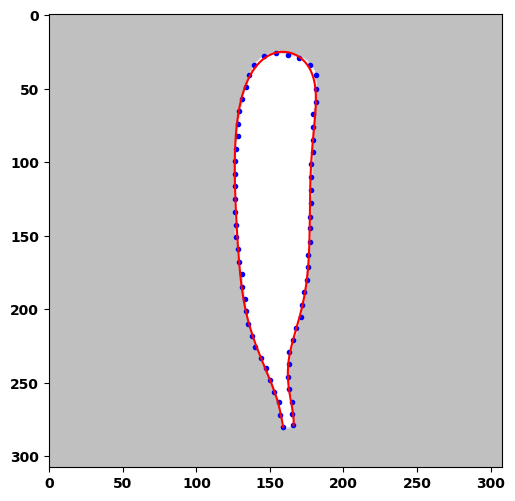

In [74]:
testOF1(imgn=8,N=11,err_th=0.5,of_th=0.5)

.............
CP 5.0, steps:12, etime: 17.03125 err: 4.9431393901
......................................................................................
CP 2.0, steps:98, etime: 107.76562 err: 1.9971274217
.
.........................................................^^^^^^^.....^^^^^^^^^^^^^^^^..........^^^..
...................^^............^.............^...........^.........^...........^.......^^.........
.....^.....................^.......^.......^.......^...............^.......^^^...............^......
.^.......^.......^.........^.......^.....^^^...........^^^.........^...^.....^...........^.....^....
.....^.......^.......^.....^.....^..................................................................
.............
CP 1.0, steps:612, etime: 670.76562 err: 0.9983868890
.......................................................................................
.................................................................................................^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(3000, 3268.9375, 0.6927915967135743, array([], dtype=int64))

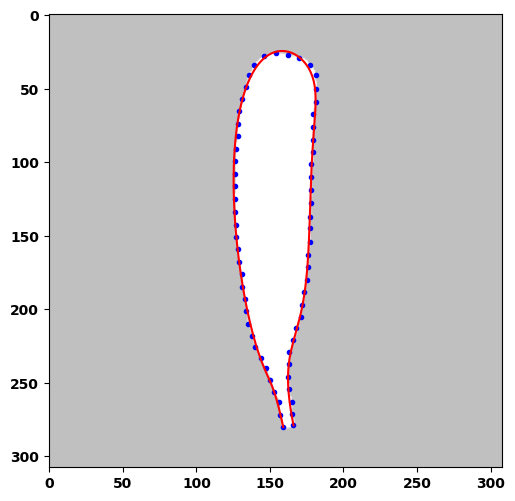

In [38]:
testOF1(imgn=8,N=8,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 7.48438 err: 1.5849642724
.
CP 2.0, steps:1, etime: 9.98438 err: 1.3267075681
.....................
CP 1.0, steps:22, etime: 62.28125 err: 0.9974093204
.............................................................................
.....................................................................................
CP 0.65, steps:184, etime: 464.90625 err: 0.6495194658
...............
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................E



(0.4999562465569043, array([], dtype=int64))

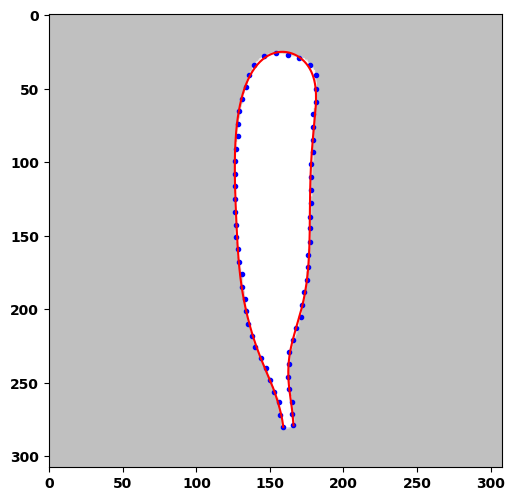

In [72]:
testOF1(imgn=8,N=13,err_th=0.5,of_th=0.5)

.
CP 5.0, steps:0, etime: 6.89062 err: 2.3299072758
.
CP 2.0, steps:1, etime: 9.03125 err: 1.9774006762
......................................................................
CP 1.0, steps:71, etime: 157.75000 err: 0.9964840246
............................
....................................................................................................
.............................................................
CP 0.65, steps:260, etime: 563.37500 err: 0.6497276067
.......................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

(0.4999695355384135, array([], dtype=int64))

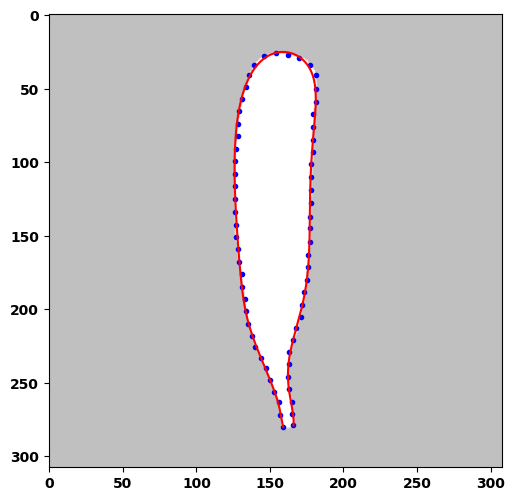

In [73]:
testOF1(imgn=8,N=12,err_th=0.5,of_th=0.5)

..
CP 5.0, steps:1, etime: 7.01562 err: 4.2995753669
...................................................................
CP 2.0, steps:68, etime: 101.23438 err: 1.9913757519
...............................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................
CP 1.0, steps:462, etime: 632.92188 err: 0.9988062474
.....................................
....................................................................................................
....................................................................................................
....................................................................................................
................................

(0.6499470940981161, array([], dtype=int64))

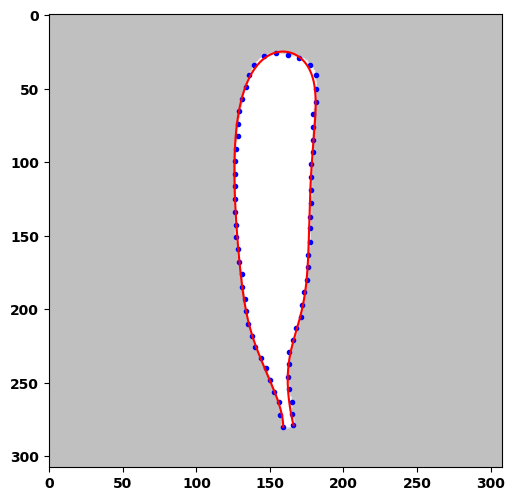

In [76]:
testOF1(imgn=8,N=9,err_th=0.65,of_th=0.65)

以下はオーバフィッティング判定が0.5固定

以下はオーバーフィッティング基準が古い、もしくはチェックなしなので数値で判断しなおすこと

ここから新しい